In [1]:
### EP3MAC0417/MAC5768
##################################################################
# AO PREENCHER ESSE CABEÇALHO COM O MEU NOME E O MEU NÚMERO USP, #
# DECLARO QUE SOU O ÚNICO AUTOR E RESPONSÁVEL PELA RESOLUÇÃO     #
# DESTE EP.                                                      #
# TODAS AS PARTES FORAM DESENVOLVIDAS E IMPLEMENTADAS POR MIM,   #
# SEGUINDO AS INSTRUÇÕES E QUE PORTANTO, NÃO CONSTITUEM          #
# DESONESTIDADE ACADÊMICA OU PLÁGIO.                             #
#                                                                #
# DECLARO TAMBÉM, QUE SOU RESPONSÁVEL POR TODAS AS CÓPIAS        #
# DESSE PROGRAMA, E QUE EU NÃO DISTRIBUI OU FACILITEI A          #
# SUA DISTRIBUIÇÃO. ESTOU CIENTE QUE OS CASOS DE PLÁGIO E        #
# DESONESTIDADE ACADÊMICA SERÃO TRATADOS SEGUNDO OS CRITÉRIOS    #
# DEFINIDOS NO CÓDIGO DE ÉTICA DA USP.                           #
#                                                                #
# ENTENDO QUE JUPYTER NOTEBOOKS SEM ASSINATURA NÃO SERÃO         #
# CORRIGIDOS E, AINDA ASSIM, PODERÃO SER PUNIDOS POR             #
# DESONESTIDADE ACADÊMICA.                                       #
#                                                                #
#                                                                #
# Nome: MARCUS VINICIUS FUGAGNOLI LARANJEIRA                     #
# NUSP: 5383459                                                  #
# Turma: MAC 0417/5768                                           #
# Prof.: Ronaldo Fumio Hashimoto                                 #
##################################################################

# EP 3 - Parte 1

Marcus Vinicius Fugagnoli Laranjeira - Número USP 5383459

In [2]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.measure import label, regionprops

## Detecção de Bordas e Contorno com Gradiente com Thresholding

In [3]:
# Diretórios contendo as imagens. Por questões de gerenciamento de memória
# para 3600 imagens, dividimos em 2 blocos de 1800 imagens cada
diretorios_1 = ['.\\originalGrayDataset',
              '.\\augmentedDataset\\contrast_stretching', 
              '.\\augmentedDataset\\exp_transform' ]
diretorios_2 = ['.\\augmentedDataset\\laplacian_img',
                '.\\augmentedDataset\\log_transform',
                '.\\augmentedDataset\\mean_img' ]

# Lista de nomes de imagens
imgs = [f"{i:04d}.png" for i in range(1, 601)]

# Gerar a lista completa de caminhos para as imagens.
imagens_1 = [os.path.join(diretorio, imagem) for diretorio in diretorios_1 for imagem in imgs]
imagens_2 = [os.path.join(diretorio, imagem) for diretorio in diretorios_2 for imagem in imgs]

In [4]:
def deteccao_bordas_gradiente(imagem, tipo_kernel = 'sobel', limiar = 0.33, dim_kernel = 3):
    """Detecta bordas em uma imagem usando o gradiente.
    
    Parameters
    ----------
        tipo_kernel (str: Tipo de Kernel à ser utilizado, prewitt ou sobel. Default: sobel
        limiar (float): limiar para o Thresholding. Defaul 0.33
        dim_kernel (int): dimensão (quadrada) do kernel. Default: 3 (3x3)
    Returns
    -------
        numpy.ndarray: A imagem convertida em tons de cinza.
    """

    # Passo 1: Suavizar a imagem (opcional, dependendo do nível de ruído)
    imagem_suavizada = cv2.GaussianBlur(imagem, (dim_kernel, dim_kernel), 2.5)  # Suavização Gaussiana

    # Passo 2: Calcular a magnitude do gradiente
    if tipo_kernel == 'sobel':
        gx = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 1, 0, ksize = dim_kernel)
        gy = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 0, 1, ksize = dim_kernel)
    elif tipo_kernel == 'prewitt':
        gx = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 1, 0, ksize = dim_kernel, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
        gy = cv2.Sobel(imagem_suavizada, cv2.CV_64F, 0, 1, ksize = dim_kernel, scale = 1, delta = 0, borderType = cv2.BORDER_DEFAULT)
    else:
        raise ValueError("Tipo de kernel inválido. Escolha 'sobel' ou 'prewitt'.")

    magnitude = np.sqrt(gx ** 2 + gy **2)
    magnitude = magnitude / np.max(magnitude)  # Normalizar para o intervalo [0, 1]

    # Passo 3: Limiarizar a magnitude do gradiente
    limiar_absoluto = limiar * np.max(magnitude)
    imagem_bordas = (magnitude >= limiar_absoluto).astype(np.uint8) * 255

    return imagem_bordas

In [5]:
def processar_imagem(imagem_path):
    """Processa imagem efetuando:
        - suavização com Gaussian Blur e detecção de bordas
        - cálculo da área dos contornos encontrados
        - traço dos contornos
         
    Parameters
    ----------
        None
    Returns
    -------
        Imagem processada, áreas e propriedades dos contornos
    """
    # Carregar a imagem
    imagem = cv2.imread(imagem_path, cv2.IMREAD_GRAYSCALE)
    
    # Verificar se a imagem foi carregada corretamente
    if imagem is None:
        print(f"Erro ao carregar a imagem: {imagem_path}")
        return None, [], []

    # 1. Suavização com Gaussian Blur e detecção de bordas
    imagem_suavizada = deteccao_bordas_gradiente(imagem, tipo_kernel = 'sobel', limiar = 0.15, dim_kernel = 7)

    # 2. Traçar contornos
    contornos, _ = cv2.findContours(imagem_suavizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Calcular e armazenar a área de cada contorno
    areas = [cv2.contourArea(c) for c in contornos]

    # 4. Traçar apenas os 3 maiores contornos
    maiores_contornos = sorted(contornos, key=cv2.contourArea, reverse=True)[:3]
    imagem_contornada = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)  # Convertendo para BGR para desenhar contornos coloridos
    cv2.drawContours(imagem_contornada, maiores_contornos, -1, (255, 0, 0), 1)

    # Convertendo imagem_contornada para colorida
    imagem_contornada_colorida = cv2.cvtColor(imagem_contornada, cv2.COLOR_BGR2RGB)
    
    # Rótulo a imagem original com contornos desenhados para análise de propriedades
    label_img = label(imagem_suavizada, connectivity=2)
    props = regionprops(label_img)

    # Filtrar props com base nas áreas dos maiores contornos
    props_filtradas = [prop for prop in props if prop.area in areas]
    props_img = props_filtradas

    return imagem_contornada_colorida, areas, props_img

In [6]:
def limpa_dir(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            # Remover link ou deletar o conteúdo (recursivo)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                for root, dirs, files in os.walk(file_path, topdown = False):
                    for name in files:
                        os.remove(os.path.join(root, name))
                    for name in dirs:
                        os.rmdir(os.path.join(root, name))
                os.rmdir(file_path)
        except Exception as e:
            print(f'Erro ao deletar {file_path}. Motivo: {e}')
            
subdirs = ['originalGrayDataset',
           'contrast_stretching',
           'log_transform',
           'exp_transform',
           'laplacian_img',
           'mean_img']

pasta_destino = 'deteccaoBorda'
diretorios_destino = ['.\\' + pasta_destino + '\\']

for subdir in subdirs:
    diretorios_destino.append(os.path.join('.\\deteccaoBorda\\', subdir + '\\'))

for dir_dest in diretorios_destino:
    if os.path.exists(dir_dest):
        # Se o diretório existir, deletar todo o conteúdo dele
        limpa_dir(dir_dest)
        print(f'Diretório {dir_dest} já existia e seu conteúdo foi apagado com sucesso.')
    else:
        # Se o diretório não existir, crio o diretório
        os.makedirs(dir_dest)
        print(f'Diretório {dir_dest} criado com sucesso.')

Diretório .\deteccaoBorda\ já existia e seu conteúdo foi apagado com sucesso.
Diretório .\deteccaoBorda\originalGrayDataset\ criado com sucesso.
Diretório .\deteccaoBorda\contrast_stretching\ criado com sucesso.
Diretório .\deteccaoBorda\log_transform\ criado com sucesso.
Diretório .\deteccaoBorda\exp_transform\ criado com sucesso.
Diretório .\deteccaoBorda\laplacian_img\ criado com sucesso.
Diretório .\deteccaoBorda\mean_img\ criado com sucesso.


In [7]:
# Lista para armazenar todas as áreas e propriedades
todas_areas = []
todas_props = []

# Lista para armazenar dados para o CSV
dados_csv = []

# Processar cada imagem
for imagem_path in imagens_1:
    imagem_processada, areas, props_img = processar_imagem(imagem_path)
    todas_areas.append(areas)
    todas_props.append(props_img)

    diretorio, nome_arquivo = os.path.split(imagem_path)
    nome_pasta = os.path.basename(diretorio)
    caminho_saida = os.path.join('.\\', pasta_destino, nome_pasta, nome_arquivo)
    cv2.imwrite(caminho_saida, cv2.cvtColor(imagem_processada, cv2.COLOR_BGR2RGB))
    
    # Ordenar áreas e props_img com base nas áreas dos contornos
    areas_props_sorted = sorted(zip(areas, props_img), key=lambda x: x[0], reverse=True)

    # Pegar as três maiores áreas e suas respectivas propriedades
    maiores_areas_props = areas_props_sorted[:3]

    # Garantir que tenhamos exatamente 3 entradas, preenchendo com valores vazios, se necessário
    while len(maiores_areas_props) < 3:
        maiores_areas_props.append((None, None))

    # Para cada uma das três maiores áreas, recuperar diâmetro e menor eixo
    for idx, (area, prop) in enumerate(maiores_areas_props):
        if area is not None and prop is not None:
            try:
                diameter = prop.major_axis_length  # Supondo que você queira o diâmetro
                minor_axis = prop.minor_axis_length  # Supondo que você queira o menor eixo
            except ValueError as e:
                print(f"Erro ao calcular propriedades: {e}")
                diameter = None
                minor_axis = None
        else:
            area = ''
            diameter = ''
            minor_axis = ''
       
        # Adicionar os dados para o CSV
        dados_csv.append({
            'Objeto': '',  # Preencha conforme necessário
            'Classe': '',  # Preencha conforme necessário
            'n_contorno': idx,
            'Área': f'{area:.2f}'.replace('.', ',') if area not in [None, ''] else '',
            'Diâmetro': f'{diameter:.15f}'.replace('.', ',') if diameter not in [None, ''] else '',
            'Minor': f'{minor_axis:.15f}'.replace('.', ',') if minor_axis not in [None, ''] else '',
            'Diretorio': diretorio,
            'Imagem': nome_arquivo
        })

        # Imprimir os dados
        print(f"Imagem: {imagem_path} - Área: {area}, Diâmetro: {diameter}, Menor: {minor_axis}")
    
    print()    
    
    # Liberar a memória das variáveis da imagem processada
    del imagem_processada
    del areas
    del props_img

Imagem: .\originalGrayDataset\0001.png - Área: 8648.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0001.png - Área: 129.0, Diâmetro: 6.249894234902776, Menor: 2.373401973657667
Imagem: .\originalGrayDataset\0001.png - Área: 55.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\originalGrayDataset\0002.png - Área: 9.5, Diâmetro: 10.327955589886445, Menor: 0.0
Imagem: .\originalGrayDataset\0002.png - Área: 8.0, Diâmetro: 9.25961033310723, Menor: 1.1223263692054242
Imagem: .\originalGrayDataset\0002.png - Área: 4.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0003.png - Área: 8654.5, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\originalGrayDataset\0003.png - Área: 129.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0003.png - Área: 106.5, Diâmetro: 5.321869122843981, Menor: 1.7826129808008924

Imagem: .\originalGrayDataset\0004.png - Área: 8653.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0004.png - Área: 133.0, Diâmetro: 8.49372773570204, Menor

Imagem: .\originalGrayDataset\0031.png - Área: 503.5, Diâmetro: 26.193252879719314, Menor: 2.52980307120456
Imagem: .\originalGrayDataset\0031.png - Área: 113.5, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\originalGrayDataset\0031.png - Área: 25.0, Diâmetro: 4.199929796800163, Menor: 1.1664431841929324

Imagem: .\originalGrayDataset\0032.png - Área: 478.5, Diâmetro: 6.052283110938236, Menor: 1.695889732428958
Imagem: .\originalGrayDataset\0032.png - Área: 24.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\originalGrayDataset\0032.png - Área: 18.0, Diâmetro: 6.553504018576144, Menor: 1.2082004568003009

Imagem: .\originalGrayDataset\0033.png - Área: 17.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0033.png - Área: 7.5, Diâmetro: 24.660424397880988, Menor: 2.888269550272038
Imagem: .\originalGrayDataset\0033.png - Área: 5.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\originalGrayDataset\0034.png - Área: 946.0, Diâmetro: 4.155374705678736, M

Imagem: .\originalGrayDataset\0060.png - Área: 717.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\originalGrayDataset\0060.png - Área: 105.5, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087
Imagem: .\originalGrayDataset\0060.png - Área: 86.0, Diâmetro: 6.410747983365109, Menor: 1.9649396885733192

Imagem: .\originalGrayDataset\0061.png - Área: 665.5, Diâmetro: 12.649110640673518, Menor: 0.0
Imagem: .\originalGrayDataset\0061.png - Área: 122.0, Diâmetro: 14.966629547095765, Menor: 0.0
Imagem: .\originalGrayDataset\0061.png - Área: 68.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\originalGrayDataset\0062.png - Área: 129.5, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\originalGrayDataset\0062.png - Área: 95.0, Diâmetro: 74.92930633694792, Menor: 3.823965353025486
Imagem: .\originalGrayDataset\0062.png - Área: 88.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0063.png - Área: 38.0, Diâmetro: 5.196736578748781, Menor: 2.5652886368981065

Imagem: .\originalGrayDataset\0088.png - Área: 3336.0, Diâmetro: 4.09878030638384, Menor: 2.9933259094191533
Imagem: .\originalGrayDataset\0088.png - Área: 2522.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\originalGrayDataset\0088.png - Área: 52.0, Diâmetro: 9.413366332749842, Menor: 1.5374462257334574

Imagem: .\originalGrayDataset\0089.png - Área: 2581.5, Diâmetro: 6.680162195068414, Menor: 2.7752411894867155
Imagem: .\originalGrayDataset\0089.png - Área: 53.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\originalGrayDataset\0089.png - Área: 38.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0090.png - Área: 3846.5, Diâmetro: 5.133805351608395, Menor: 1.5423153015346889
Imagem: .\originalGrayDataset\0090.png - Área: 2579.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0090.png - Área: 53.0, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\originalGrayDataset\0091.png - Área: 120.5, Diâmetro: 11.489125293076057, Menor: 0.0
Imagem: .\

Imagem: .\originalGrayDataset\0117.png - Área: 1800.5, Diâmetro: 10.651211095872176, Menor: 1.6965355296646067
Imagem: .\originalGrayDataset\0117.png - Área: 109.5, Diâmetro: 5.274258481434536, Menor: 1.946056459258261
Imagem: .\originalGrayDataset\0117.png - Área: 63.5, Diâmetro: 13.876614822361814, Menor: 1.2498040051944983

Imagem: .\originalGrayDataset\0118.png - Área: 53.0, Diâmetro: 7.141921394560869, Menor: 1.9130147570210732
Imagem: .\originalGrayDataset\0118.png - Área: 29.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\originalGrayDataset\0118.png - Área: 17.0, Diâmetro: 11.489125293076057, Menor: 0.0

Imagem: .\originalGrayDataset\0119.png - Área: 51.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0119.png - Área: 16.5, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\originalGrayDataset\0119.png - Área: 12.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0120.png - Área: 45.0, Diâmetro: 7.554371880072024, Menor: 1.9753176197160076
Imagem: .\origin

Imagem: .\originalGrayDataset\0144.png - Área: 29768.5, Diâmetro: 5.376796813410203, Menor: 2.9933056162892875
Imagem: .\originalGrayDataset\0144.png - Área: 4138.0, Diâmetro: 15.010712207529663, Menor: 4.426037278027047
Imagem: .\originalGrayDataset\0144.png - Área: 2613.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317

Imagem: .\originalGrayDataset\0145.png - Área: 30219.5, Diâmetro: 6.2451716576976395, Menor: 3.19144653188646
Imagem: .\originalGrayDataset\0145.png - Área: 4605.0, Diâmetro: 11.726107268787999, Menor: 2.5750028593840395
Imagem: .\originalGrayDataset\0145.png - Área: 2649.5, Diâmetro: 5.7681210284018105, Menor: 3.289022452127339

Imagem: .\originalGrayDataset\0146.png - Área: 29825.5, Diâmetro: 7.3781999613471045, Menor: 2.7838220723274665
Imagem: .\originalGrayDataset\0146.png - Área: 9891.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0146.png - Área: 5180.0, Diâmetro: 5.945590686091159, Menor: 2.1189505405898594

Imagem: .\originalGrayDataset\01

Imagem: .\originalGrayDataset\0171.png - Área: 16557.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\originalGrayDataset\0171.png - Área: 13948.5, Diâmetro: 7.145438345523728, Menor: 3.7263952431157263
Imagem: .\originalGrayDataset\0171.png - Área: 6663.0, Diâmetro: 17.66352203197482, Menor: 4.5294657572532815

Imagem: .\originalGrayDataset\0172.png - Área: 16292.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0172.png - Área: 14977.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\originalGrayDataset\0172.png - Área: 5388.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\originalGrayDataset\0173.png - Área: 16266.5, Diâmetro: 9.307199519293546, Menor: 4.753397427952135
Imagem: .\originalGrayDataset\0173.png - Área: 14147.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0173.png - Área: 2761.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317

Imagem: .\originalGrayDataset\0174.png - Áre

Imagem: .\originalGrayDataset\0198.png - Área: 36339.5, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\originalGrayDataset\0198.png - Área: 1591.0, Diâmetro: 8.732552396335315, Menor: 2.6367413958270967
Imagem: .\originalGrayDataset\0198.png - Área: 1300.5, Diâmetro: 6.843275670546393, Menor: 2.94441472909436

Imagem: .\originalGrayDataset\0199.png - Área: 36275.5, Diâmetro: 5.896459480240757, Menor: 1.3428306554839582
Imagem: .\originalGrayDataset\0199.png - Área: 4089.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\originalGrayDataset\0199.png - Área: 1409.5, Diâmetro: 7.30123226034564, Menor: 3.1137545966406135

Imagem: .\originalGrayDataset\0200.png - Área: 7959.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0200.png - Área: 4937.5, Diâmetro: 6.491432935357954, Menor: 3.2157889305347775
Imagem: .\originalGrayDataset\0200.png - Área: 3533.5, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452

Imagem: .\originalGrayDataset\0201.png - Área: 10899

Imagem: .\originalGrayDataset\0225.png - Área: 14900.5, Diâmetro: 4.894994431930091, Menor: 2.9693109114997
Imagem: .\originalGrayDataset\0225.png - Área: 12205.0, Diâmetro: 6.0028557215317315, Menor: 2.963452330827342
Imagem: .\originalGrayDataset\0225.png - Área: 5537.0, Diâmetro: 7.554371880072024, Menor: 1.9753176197160076

Imagem: .\originalGrayDataset\0226.png - Área: 20701.5, Diâmetro: 5.963268946242257, Menor: 3.2213663642250534
Imagem: .\originalGrayDataset\0226.png - Área: 14032.0, Diâmetro: 17.31314078347122, Menor: 7.5433417794107696
Imagem: .\originalGrayDataset\0226.png - Área: 5052.5, Diâmetro: 4.375345285424217, Menor: 2.089630999709932

Imagem: .\originalGrayDataset\0227.png - Área: 19922.0, Diâmetro: 15.226571574961035, Menor: 4.379845536598581
Imagem: .\originalGrayDataset\0227.png - Área: 15195.0, Diâmetro: 4.0, Menor: 1.3856406460551018
Imagem: .\originalGrayDataset\0227.png - Área: 6471.0, Diâmetro: 20.122329761895912, Menor: 3.8662187499744234

Imagem: .\original

Imagem: .\originalGrayDataset\0254.png - Área: 6995.0, Diâmetro: 5.606119105813881, Menor: 3.0237157840738176
Imagem: .\originalGrayDataset\0254.png - Área: 130.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\originalGrayDataset\0254.png - Área: 15.0, Diâmetro: 7.049811475828224, Menor: 1.7868184403435534

Imagem: .\originalGrayDataset\0255.png - Área: 103.0, Diâmetro: 21.53470507808633, Menor: 7.604619341540547
Imagem: .\originalGrayDataset\0255.png - Área: 16.5, Diâmetro: 6.449983629915197, Menor: 2.908596464972101
Imagem: .\originalGrayDataset\0255.png - Área: 16.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317

Imagem: .\originalGrayDataset\0256.png - Área: 5437.0, Diâmetro: 5.055900530816918, Menor: 3.1378581622109447
Imagem: .\originalGrayDataset\0256.png - Área: 274.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0256.png - Área: 35.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0257.png - Área: 5455.5, Diâmetro: 5.274258481434

Imagem: .\originalGrayDataset\0285.png - Área: 6.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\originalGrayDataset\0285.png - Área: 3.5, Diâmetro: 4.27617987059879, Menor: 2.285714285714286
Imagem: .\originalGrayDataset\0285.png - Área: 0.0, Diâmetro: 5.274258481434536, Menor: 1.946056459258261

Imagem: .\originalGrayDataset\0286.png - Área: 0.0, Diâmetro: 5.23606797749979, Menor: 0.7639320225002099
Imagem: .\originalGrayDataset\0286.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0286.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0287.png - Área: 5.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0287.png - Área: 0.0, Diâmetro: 9.949844043367323, Menor: 2.347402565289248
Imagem: .\originalGrayDataset\0287.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0288.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0288.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0

Imagem: .\originalGrayDataset\0321.png - Área: 36.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0321.png - Área: 7.5, Diâmetro: 7.264631388282042, Menor: 3.7393181740659363
Imagem: .\originalGrayDataset\0321.png - Área: 7.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\originalGrayDataset\0322.png - Área: 107.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0322.png - Área: 37.5, Diâmetro: 5.055959348388901, Menor: 2.6889893077494644
Imagem: .\originalGrayDataset\0322.png - Área: 15.5, Diâmetro: 2.0, Menor: 2.0

Imagem: .\originalGrayDataset\0323.png - Área: 25.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0323.png - Área: 13.0, Diâmetro: 7.656879096300145, Menor: 2.317801221986448
Imagem: .\originalGrayDataset\0323.png - Área: 8.0, Diâmetro: 4.1204045563213505, Menor: 2.4025541184843804

Imagem: .\originalGrayDataset\0324.png - Área: 211.5, Diâmetro: 34.05920653603394, Menor: 8.450005468677091
Imagem: .\originalGrayDataset\0324.

Imagem: .\originalGrayDataset\0354.png - Área: 61.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0354.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0354.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0355.png - Área: 8.0, Diâmetro: 6.707279387142534, Menor: 2.5857054377032167
Imagem: .\originalGrayDataset\0355.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0355.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0356.png - Área: 7.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0356.png - Área: 0.0, Diâmetro: 8.0, Menor: 0.0
Imagem: .\originalGrayDataset\0356.png - Área: 0.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\originalGrayDataset\0357.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0357.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0357.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0358.png - Área: , Diâmetro: , Menor: 
I

Imagem: .\originalGrayDataset\0390.png - Área: 397.0, Diâmetro: 9.979584798628613, Menor: 1.7378527397164276
Imagem: .\originalGrayDataset\0390.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0390.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0391.png - Área: 1.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\originalGrayDataset\0391.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0391.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0392.png - Área: 3.5, Diâmetro: 4.09878030638384, Menor: 2.9933259094191533
Imagem: .\originalGrayDataset\0392.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0392.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0393.png - Área: 50.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0393.png - Área: 2.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0393.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0394.png - 

Imagem: .\originalGrayDataset\0424.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0424.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0424.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0425.png - Área: 125.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0425.png - Área: 2.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\originalGrayDataset\0425.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0426.png - Área: 137.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0426.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0426.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0427.png - Área: 7.0, Diâmetro: 29.37865317151452, Menor: 1.998156295092361
Imagem: .\originalGrayDataset\0427.png - Área: , Diâmetro: , Menor: 
Imagem: .\originalGrayDataset\0427.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0428.png - Ár

Imagem: .\originalGrayDataset\0456.png - Área: 277.0, Diâmetro: 7.6573913395197915, Menor: 1.168057307432856
Imagem: .\originalGrayDataset\0456.png - Área: 28.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\originalGrayDataset\0456.png - Área: 6.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\originalGrayDataset\0457.png - Área: 44.5, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306
Imagem: .\originalGrayDataset\0457.png - Área: 41.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\originalGrayDataset\0457.png - Área: , Diâmetro: , Menor: 

Imagem: .\originalGrayDataset\0458.png - Área: 24.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\originalGrayDataset\0458.png - Área: 12.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\originalGrayDataset\0458.png - Área: 11.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\originalGrayDataset\0459.png - Área: 0.0, Diâmetro: 16.6796204216438, Menor: 4.025037243797434
Imagem: .\origina

Imagem: .\originalGrayDataset\0488.png - Área: 33.5, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\originalGrayDataset\0488.png - Área: 33.0, Diâmetro: 4.381780460041329, Menor: 2.6832815729997477
Imagem: .\originalGrayDataset\0488.png - Área: 25.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0489.png - Área: 4258.0, Diâmetro: 11.304606290625843, Menor: 3.9908296663346214
Imagem: .\originalGrayDataset\0489.png - Área: 1094.5, Diâmetro: 4.312594463574638, Menor: 2.660928660904759
Imagem: .\originalGrayDataset\0489.png - Área: 287.5, Diâmetro: 4.51260859854213, Menor: 2.9541957835039856

Imagem: .\originalGrayDataset\0490.png - Área: 7312.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\originalGrayDataset\0490.png - Área: 88.0, Diâmetro: 4.976979969245306, Menor: 1.7971283720789095
Imagem: .\originalGrayDataset\0490.png - Área: 85.0, Diâmetro: 3.885753375057407, Menor: 2.7954428906961324

Imagem: .\originalGrayDataset\0491.png - Área: 

Imagem: .\originalGrayDataset\0517.png - Área: 5626.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0517.png - Área: 338.0, Diâmetro: 4.976979969245306, Menor: 1.7971283720789095
Imagem: .\originalGrayDataset\0517.png - Área: 57.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\originalGrayDataset\0518.png - Área: 6711.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\originalGrayDataset\0518.png - Área: 121.0, Diâmetro: 7.15733956975279, Menor: 2.661503596533745
Imagem: .\originalGrayDataset\0518.png - Área: 100.5, Diâmetro: 4.0, Menor: 3.1496031496047245

Imagem: .\originalGrayDataset\0519.png - Área: 1241.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\originalGrayDataset\0519.png - Área: 747.5, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\originalGrayDataset\0519.png - Área: 326.5, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272

Imagem: .\originalGrayDataset\0520.png - Área: 3348.0, Diâmetro: 3.098386676965933, Men

Imagem: .\originalGrayDataset\0545.png - Área: 3672.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\originalGrayDataset\0545.png - Área: 1367.5, Diâmetro: 4.47213595499958, Menor: 2.0
Imagem: .\originalGrayDataset\0545.png - Área: 818.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\originalGrayDataset\0546.png - Área: 1031.5, Diâmetro: 2.0, Menor: 2.0
Imagem: .\originalGrayDataset\0546.png - Área: 804.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\originalGrayDataset\0546.png - Área: 308.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\originalGrayDataset\0547.png - Área: 499.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\originalGrayDataset\0547.png - Área: 216.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\originalGrayDataset\0547.png - Área: 133.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\originalGrayDataset\0548.png - Área: 137.0, Diâmetro: 5.00274675656753, Menor: 1.4434805162398887
Imagem: .\originalGrayDataset\0548.png - Área: 118.0, Diâmetro:

Imagem: .\originalGrayDataset\0573.png - Área: 651.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0573.png - Área: 266.5, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\originalGrayDataset\0573.png - Área: 213.5, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452

Imagem: .\originalGrayDataset\0574.png - Área: 109.0, Diâmetro: 15.637197569707421, Menor: 6.127211590464898
Imagem: .\originalGrayDataset\0574.png - Área: 100.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\originalGrayDataset\0574.png - Área: 86.5, Diâmetro: 10.124575026083088, Menor: 3.416210668871879

Imagem: .\originalGrayDataset\0575.png - Área: 4285.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\originalGrayDataset\0575.png - Área: 1489.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\originalGrayDataset\0575.png - Área: 258.0, Diâmetro: 7.2557272110818545, Menor: 4.393047584856187

Imagem: .\originalGrayDataset\0576.png - Área: 4405.5, Diâmetro: 4.199929796800163, Menor: 1.1664431841929324
Imagem:

Imagem: .\augmentedDataset\contrast_stretching\0002.png - Área: 10.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0002.png - Área: 9.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0002.png - Área: 5.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0003.png - Área: 8651.0, Diâmetro: 6.052283110938236, Menor: 1.695889732428958
Imagem: .\augmentedDataset\contrast_stretching\0003.png - Área: 129.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0003.png - Área: 102.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0004.png - Área: 8651.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\contrast_stretching\0004.png - Área: 135.0, Diâmetro: 4.680205767201096, Menor: 1.046744465787899
Imagem: .\augmentedDataset\contrast_stretching\0004.png - Área: 128.0, Diâmetro: 9.179476518602309, Menor: 3.9628

Imagem: .\augmentedDataset\contrast_stretching\0029.png - Área: 7.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0029.png - Área: 3.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0029.png - Área: 0.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0030.png - Área: 6.0, Diâmetro: 4.82842712474619, Menor: 0.8284271247461902
Imagem: .\augmentedDataset\contrast_stretching\0030.png - Área: 4.0, Diâmetro: 6.147097018697723, Menor: 2.678035834089599
Imagem: .\augmentedDataset\contrast_stretching\0030.png - Área: 3.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\contrast_stretching\0031.png - Área: 508.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0031.png - Área: 24.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0031.png - Área: 10.0, Diâmetro: 0.

Imagem: .\augmentedDataset\contrast_stretching\0055.png - Área: 127.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0055.png - Área: 90.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0055.png - Área: 73.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0056.png - Área: 122.0, Diâmetro: 6.585670706008097, Menor: 3.1796084995103278
Imagem: .\augmentedDataset\contrast_stretching\0056.png - Área: 84.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0056.png - Área: 65.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0057.png - Área: 8958.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0057.png - Área: 2865.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0057.png - Área: 114.0, Diâmetro: 6.0008543671008105, Menor: 1.9725570797187

I

Imagem: .\augmentedDataset\contrast_stretching\0079.png - Área: 3324.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0079.png - Área: 103.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0079.png - Área: 70.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0080.png - Área: 4352.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0080.png - Área: 724.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0080.png - Área: 112.0, Diâmetro: 7.304621148395339, Menor: 2.4967220489126656

Imagem: .\augmentedDataset\contrast_stretching\0081.png - Área: 2006.5, Diâmetro: 8.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0081.png - Área: 761.0, Diâmetro: 5.163977794943222, Menor: 1.4907119849998602
Imagem: .\augmentedDataset\contrast_stretching\0081.png - Área: 132.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\

Imagem: .\augmentedDataset\contrast_stretching\0106.png - Área: 2251.0, Diâmetro: 4.507893913753563, Menor: 2.104493398028036
Imagem: .\augmentedDataset\contrast_stretching\0106.png - Área: 79.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0106.png - Área: 51.0, Diâmetro: 5.444424563872507, Menor: 2.2534953224494765

Imagem: .\augmentedDataset\contrast_stretching\0107.png - Área: 657.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0107.png - Área: 46.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0107.png - Área: 16.5, Diâmetro: 4.363338213437162, Menor: 1.65500979239906

Imagem: .\augmentedDataset\contrast_stretching\0108.png - Área: 86.5, Diâmetro: 8.1962219648716, Menor: 1.7126168905121215
Imagem: .\augmentedDataset\contrast_stretching\0108.png - Área: 64.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0108.png - Área: 49.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmented

Imagem: .\augmentedDataset\contrast_stretching\0130.png - Área: 29713.5, Diâmetro: 5.033222956847167, Menor: 2.9059326290271157
Imagem: .\augmentedDataset\contrast_stretching\0130.png - Área: 3535.0, Diâmetro: 8.278704359656585, Menor: 3.740432047662519
Imagem: .\augmentedDataset\contrast_stretching\0130.png - Área: 1051.0, Diâmetro: 3.265986323710904, Menor: 2.0

Imagem: .\augmentedDataset\contrast_stretching\0131.png - Área: 35521.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0131.png - Área: 29545.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0131.png - Área: 1435.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\augmentedDataset\contrast_stretching\0132.png - Área: 29754.5, Diâmetro: 4.898979485566356, Menor: 1.9364916731037085
Imagem: .\augmentedDataset\contrast_stretching\0132.png - Área: 5424.5, Diâmetro: 5.90407596419126, Menor: 2.6093205390916836
Imagem: .\augmentedDataset\contrast_stretching\0132.

Imagem: .\augmentedDataset\contrast_stretching\0153.png - Área: 30167.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0153.png - Área: 10604.0, Diâmetro: 6.842316735992748, Menor: 4.188736501110658
Imagem: .\augmentedDataset\contrast_stretching\0153.png - Área: 5130.5, Diâmetro: 2.8284271247461903, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0154.png - Área: 30322.5, Diâmetro: 4.132908103676025, Menor: 2.8640916926406166
Imagem: .\augmentedDataset\contrast_stretching\0154.png - Área: 3373.5, Diâmetro: 11.466600381562172, Menor: 10.002756593276455
Imagem: .\augmentedDataset\contrast_stretching\0154.png - Área: 3085.0, Diâmetro: 8.13150332548484, Menor: 2.500730626762709

Imagem: .\augmentedDataset\contrast_stretching\0155.png - Área: 30240.5, Diâmetro: 4.0, Menor: 1.3856406460551023
Imagem: .\augmentedDataset\contrast_stretching\0155.png - Área: 5400.5, Diâmetro: 6.910694415125243, Menor: 2.4435011279893395
Imagem: .\augmentedDataset\contrast_s

Imagem: .\augmentedDataset\contrast_stretching\0176.png - Área: 15124.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0176.png - Área: 2984.0, Diâmetro: 5.203549084703927, Menor: 3.076923076923077
Imagem: .\augmentedDataset\contrast_stretching\0176.png - Área: 772.0, Diâmetro: 4.0, Menor: 2.2131333406899523

Imagem: .\augmentedDataset\contrast_stretching\0177.png - Área: 36340.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0177.png - Área: 14837.5, Diâmetro: 8.085128209831346, Menor: 2.41130157798172
Imagem: .\augmentedDataset\contrast_stretching\0177.png - Área: 1478.0, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\contrast_stretching\0178.png - Área: 34693.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087
Imagem: .\augmentedDataset\contrast_stretching\0178.png - Área: 14227.5, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452
Imagem: .\augmentedDataset\contrast_stretching\0178.png - Área: 4273

Imagem: .\augmentedDataset\contrast_stretching\0199.png - Área: 36243.5, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306
Imagem: .\augmentedDataset\contrast_stretching\0199.png - Área: 4063.0, Diâmetro: 5.632180985491135, Menor: 1.8106731750020786
Imagem: .\augmentedDataset\contrast_stretching\0199.png - Área: 1319.5, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641265

Imagem: .\augmentedDataset\contrast_stretching\0200.png - Área: 7973.5, Diâmetro: 10.157090376400708, Menor: 2.546465121440701
Imagem: .\augmentedDataset\contrast_stretching\0200.png - Área: 4938.5, Diâmetro: 11.672106958832956, Menor: 3.3131765901898564
Imagem: .\augmentedDataset\contrast_stretching\0200.png - Área: 3554.0, Diâmetro: 5.294328785763617, Menor: 2.862220279862641

Imagem: .\augmentedDataset\contrast_stretching\0201.png - Área: 8535.5, Diâmetro: 8.260632653342173, Menor: 2.873286502775329
Imagem: .\augmentedDataset\contrast_stretching\0201.png - Área: 5619.0, Diâmetro: 4.569200140512702, Menor:

Imagem: .\augmentedDataset\contrast_stretching\0222.png - Área: 35332.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\contrast_stretching\0222.png - Área: 2614.0, Diâmetro: 10.79230352413712, Menor: 4.06991976906604
Imagem: .\augmentedDataset\contrast_stretching\0222.png - Área: 2432.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\augmentedDataset\contrast_stretching\0223.png - Área: 35336.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0223.png - Área: 2504.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0223.png - Área: 603.5, Diâmetro: 7.5618257082314795, Menor: 2.892916343192472

Imagem: .\augmentedDataset\contrast_stretching\0224.png - Área: 35358.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0224.png - Área: 4473.0, Diâmetro: 13.932877227263024, Menor: 4.365195547740723
Imagem: .\augmentedDatas

Imagem: .\augmentedDataset\contrast_stretching\0250.png - Área: 6843.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0250.png - Área: 120.5, Diâmetro: 2.8284271247461903, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0250.png - Área: 84.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0251.png - Área: 170.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0251.png - Área: 46.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\contrast_stretching\0251.png - Área: 13.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0252.png - Área: 197.5, Diâmetro: 6.2869935679309235, Menor: 2.54667355511495
Imagem: .\augmentedDataset\contrast_stretching\0252.png - Área: 3.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0252.png - Área: , Diâmetro: , Menor: 

Imagem: .\

Imagem: .\augmentedDataset\contrast_stretching\0275.png - Área: 18.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0275.png - Área: 8.0, Diâmetro: 6.74931065175226, Menor: 1.9751838346566482
Imagem: .\augmentedDataset\contrast_stretching\0275.png - Área: 6.0, Diâmetro: 6.011486661777879, Menor: 1.2805490592103137

Imagem: .\augmentedDataset\contrast_stretching\0276.png - Área: 172.5, Diâmetro: 4.743365517193277, Menor: 1.3492529674978493
Imagem: .\augmentedDataset\contrast_stretching\0276.png - Área: 161.0, Diâmetro: 7.000091071529563, Menor: 1.904422265109768
Imagem: .\augmentedDataset\contrast_stretching\0276.png - Área: 18.0, Diâmetro: 5.23606797749979, Menor: 0.7639320225002099

Imagem: .\augmentedDataset\contrast_stretching\0277.png - Área: 304.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0277.png - Área: 22.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\c

Imagem: .\augmentedDataset\contrast_stretching\0303.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0303.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0303.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0304.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0304.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0304.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0305.png - Área: 375.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0305.png - Área: 273.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0305.png - Área: 177.0, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951

Imagem: .\augmentedDataset\contrast_stretching\0306.png - Área: 572.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0306.png - Área:

Imagem: .\augmentedDataset\contrast_stretching\0330.png - Área: 487.0, Diâmetro: 6.825641401682367, Menor: 4.696233638283426
Imagem: .\augmentedDataset\contrast_stretching\0330.png - Área: 181.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0330.png - Área: 21.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0331.png - Área: 1035.0, Diâmetro: 10.508125960396756, Menor: 1.4986512159613496
Imagem: .\augmentedDataset\contrast_stretching\0331.png - Área: 438.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\contrast_stretching\0331.png - Área: 175.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0332.png - Área: 241.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0332.png - Área: 187.5, Diâmetro: 11.279393864976262, Menor: 1.6632453666993894
Imagem: .\augmentedDataset\contrast_stretching\0332.png - Área: 179.0, Diâmetro: 3.26598632

Imagem: .\augmentedDataset\contrast_stretching\0359.png - Área: 7.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0359.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0359.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0360.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0360.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0360.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0361.png - Área: 818.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0361.png - Área: 104.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0361.png - Área: 102.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0362.png - Área: 375.0, Diâmetro: 4.93861174764721, Menor: 1.6496136266144523
Imagem: .\augmentedDataset\contrast_stretching\0362.png 

Imagem: .\augmentedDataset\contrast_stretching\0386.png - Área: 1006.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0386.png - Área: 6.0, Diâmetro: 4.093338188813542, Menor: 1.563516060678838
Imagem: .\augmentedDataset\contrast_stretching\0386.png - Área: 2.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0387.png - Área: 1205.0, Diâmetro: 4.680205767201096, Menor: 1.046744465787899
Imagem: .\augmentedDataset\contrast_stretching\0387.png - Área: 919.0, Diâmetro: 31.153373248190903, Menor: 4.048594449497799
Imagem: .\augmentedDataset\contrast_stretching\0387.png - Área: 663.5, Diâmetro: 6.204045653994718, Menor: 2.148780011931926

Imagem: .\augmentedDataset\contrast_stretching\0388.png - Área: 2344.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0388.png - Área: 805.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\contrast_stretching\0388.

Imagem: .\augmentedDataset\contrast_stretching\0414.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0414.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0414.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0415.png - Área: 3.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\contrast_stretching\0415.png - Área: 1.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0415.png - Área: 0.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\augmentedDataset\contrast_stretching\0416.png - Área: 14112.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0416.png - Área: 3585.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\contrast_stretching\0416.png - Área: 14.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0417.png - Área: 616.0, 

Imagem: .\augmentedDataset\contrast_stretching\0443.png - Área: 63.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0443.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0443.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0444.png - Área: 75.5, Diâmetro: 5.444424563872507, Menor: 2.2534953224494765
Imagem: .\augmentedDataset\contrast_stretching\0444.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0444.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0445.png - Área: 0.0, Diâmetro: 5.77331086475517, Menor: 1.1085493488789315
Imagem: .\augmentedDataset\contrast_stretching\0445.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0445.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contrast_stretching\0446.png - Área: 93.5, Diâmetro: 4.363338213437162, Menor: 1.65500979239906
Imagem: .\augm

Imagem: .\augmentedDataset\contrast_stretching\0474.png - Área: 478.0, Diâmetro: 12.183721972578796, Menor: 1.8859795584524948
Imagem: .\augmentedDataset\contrast_stretching\0474.png - Área: 25.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0474.png - Área: 8.0, Diâmetro: 4.507893913753563, Menor: 2.104493398028036

Imagem: .\augmentedDataset\contrast_stretching\0475.png - Área: 538.0, Diâmetro: 9.565904485341061, Menor: 3.069053797515205
Imagem: .\augmentedDataset\contrast_stretching\0475.png - Área: 91.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0475.png - Área: 22.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0476.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0476.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\contrast_stretching\0476.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\contra

Imagem: .\augmentedDataset\contrast_stretching\0501.png - Área: 27.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0501.png - Área: 21.5, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\contrast_stretching\0501.png - Área: 16.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0502.png - Área: 751.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0502.png - Área: 305.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0502.png - Área: 63.5, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\augmentedDataset\contrast_stretching\0503.png - Área: 3384.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0503.png - Área: 1015.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0503.png - Área: 762.5, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDatas

Imagem: .\augmentedDataset\contrast_stretching\0525.png - Área: 32.5, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\contrast_stretching\0525.png - Área: 24.0, Diâmetro: 4.8074017006186525, Menor: 2.3094010767585025
Imagem: .\augmentedDataset\contrast_stretching\0525.png - Área: 20.0, Diâmetro: 8.199213623250282, Menor: 2.8649256547768185

Imagem: .\augmentedDataset\contrast_stretching\0526.png - Área: 3487.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0526.png - Área: 2920.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0526.png - Área: 623.0, Diâmetro: 8.862638236308426, Menor: 4.760933243310442

Imagem: .\augmentedDataset\contrast_stretching\0527.png - Área: 60.0, Diâmetro: 4.972652484064489, Menor: 2.745394340098455
Imagem: .\augmentedDataset\contrast_stretching\0527.png - Área: 32.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0527.png - Área: 24.5, Diâmetro: 5.685009884989297, Menor: 2.34

Imagem: .\augmentedDataset\contrast_stretching\0550.png - Área: 3196.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0550.png - Área: 448.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\contrast_stretching\0550.png - Área: 325.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0551.png - Área: 2330.0, Diâmetro: 3.7032803990902057, Menor: 2.138089935299395
Imagem: .\augmentedDataset\contrast_stretching\0551.png - Área: 568.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0551.png - Área: 246.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0552.png - Área: 167.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0552.png - Área: 128.5, Diâmetro: 18.62881457390555, Menor: 4.847337344950322
Imagem: .\augmentedDataset\contrast_stretching\0552.png - Área: 109.5, Diâmetro: 8.967407896136747, Menor: 4.8805707273129775

Imagem: .

Imagem: .\augmentedDataset\contrast_stretching\0574.png - Área: 111.0, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772
Imagem: .\augmentedDataset\contrast_stretching\0574.png - Área: 101.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\augmentedDataset\contrast_stretching\0574.png - Área: 87.5, Diâmetro: 5.967366459522714, Menor: 2.749933666636243

Imagem: .\augmentedDataset\contrast_stretching\0575.png - Área: 4299.0, Diâmetro: 7.704827029912549, Menor: 2.5515956652904435
Imagem: .\augmentedDataset\contrast_stretching\0575.png - Área: 1499.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\contrast_stretching\0575.png - Área: 252.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\contrast_stretching\0576.png - Área: 160.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\contrast_stretching\0576.png - Área: 143.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0

Imagem: .\augmentedDataset\contrast_stretching\0599.png - Área: 2623.0, Diâmetro: 7.491648016825107, Menor: 1.9401285732882028
Imagem: .\augmentedDataset\contrast_stretching\0599.png - Área: 463.0, Diâmetro: 21.164430217358113, Menor: 1.7745249389296032
Imagem: .\augmentedDataset\contrast_stretching\0599.png - Área: 397.0, Diâmetro: 12.869513617390906, Menor: 3.9554543672996747

Imagem: .\augmentedDataset\contrast_stretching\0600.png - Área: 290.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0600.png - Área: 13.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\contrast_stretching\0600.png - Área: 13.0, Diâmetro: 5.274258481434536, Menor: 1.946056459258261

Imagem: .\augmentedDataset\exp_transform\0001.png - Área: 10.5, Diâmetro: 4.34169545110285, Menor: 1.27658944452507
Imagem: .\augmentedDataset\exp_transform\0001.png - Área: 8.0, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0001.png - Área: 6.0, Diâmetro: 3.236067

Imagem: .\augmentedDataset\exp_transform\0025.png - Área: 1712.0, Diâmetro: 4.976979969245306, Menor: 1.7971283720789095
Imagem: .\augmentedDataset\exp_transform\0025.png - Área: 313.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0025.png - Área: 152.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0026.png - Área: 3675.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\exp_transform\0026.png - Área: 313.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\exp_transform\0026.png - Área: 112.0, Diâmetro: 7.004060199219788, Menor: 2.975428595644902

Imagem: .\augmentedDataset\exp_transform\0027.png - Área: 151.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0027.png - Área: 126.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0027.png - Área: 75.0, Diâmetro: 2.0, Menor: 0.0

Ima

Imagem: .\augmentedDataset\exp_transform\0051.png - Área: 8979.0, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0051.png - Área: 171.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\exp_transform\0051.png - Área: 95.5, Diâmetro: 4.976979969245306, Menor: 1.7971283720789095

Imagem: .\augmentedDataset\exp_transform\0052.png - Área: 9000.5, Diâmetro: 11.82771560836674, Menor: 2.702802894699829
Imagem: .\augmentedDataset\exp_transform\0052.png - Área: 6096.5, Diâmetro: 12.316411610857859, Menor: 5.83739974656152
Imagem: .\augmentedDataset\exp_transform\0052.png - Área: 4511.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0053.png - Área: 8970.5, Diâmetro: 7.563396510518426, Menor: 1.565041281350756
Imagem: .\augmentedDataset\exp_transform\0053.png - Área: 132.0, Diâmetro: 13.426027989997575, Menor: 4.764498934594493
Imagem: .\augmentedDataset\exp_transform\0053.png - Área: 92.0, Diâmetro: 0.0, Men

Imagem: .\augmentedDataset\exp_transform\0079.png - Área: 3319.5, Diâmetro: 11.268388777475916, Menor: 1.8555773888670264
Imagem: .\augmentedDataset\exp_transform\0079.png - Área: 97.0, Diâmetro: 6.040895836088439, Menor: 1.8728527698485424
Imagem: .\augmentedDataset\exp_transform\0079.png - Área: 35.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0080.png - Área: 724.5, Diâmetro: 13.191866749702658, Menor: 1.890674921314987
Imagem: .\augmentedDataset\exp_transform\0080.png - Área: 110.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0080.png - Área: 66.5, Diâmetro: 6.586417573021535, Menor: 1.685623260404093

Imagem: .\augmentedDataset\exp_transform\0081.png - Área: 2006.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0081.png - Área: 756.5, Diâmetro: 7.554371880072024, Menor: 1.9753176197160076
Imagem: .\augmentedDataset\exp_transform\0081.png - Ár

Imagem: .\augmentedDataset\exp_transform\0105.png - Área: 90.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0105.png - Área: 67.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0105.png - Área: 63.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0106.png - Área: 2250.0, Diâmetro: 6.052283110938236, Menor: 1.695889732428958
Imagem: .\augmentedDataset\exp_transform\0106.png - Área: 1270.5, Diâmetro: 5.656854249492381, Menor: 2.0
Imagem: .\augmentedDataset\exp_transform\0106.png - Área: 76.0, Diâmetro: 9.759674232165072, Menor: 3.611034229948465

Imagem: .\augmentedDataset\exp_transform\0107.png - Área: 64.0, Diâmetro: 8.010001139542341, Menor: 3.1685772429483845
Imagem: .\augmentedDataset\exp_transform\0107.png - Área: 58.5, Diâmetro: 4.0, Menor: 1.3856406460551023
Imagem: .\augmentedDataset\exp_transform\0107.png - Área: 49.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\augmentedDataset

Imagem: .\augmentedDataset\exp_transform\0130.png - Área: 29693.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\exp_transform\0130.png - Área: 3453.0, Diâmetro: 6.5198813347471125, Menor: 4.1729587889106226
Imagem: .\augmentedDataset\exp_transform\0130.png - Área: 1044.5, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772

Imagem: .\augmentedDataset\exp_transform\0131.png - Área: 35509.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0131.png - Área: 29535.5, Diâmetro: 14.748716639640243, Menor: 5.377186345460147
Imagem: .\augmentedDataset\exp_transform\0131.png - Área: 1443.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\exp_transform\0132.png - Área: 29762.5, Diâmetro: 10.917135768732173, Menor: 3.5686538755399457
Imagem: .\augmentedDataset\exp_transform\0132.png - Área: 5301.0, Diâmetro: 6.155367074350507, Menor: 1.4530850560107218
Imagem: .\augmentedDatas

Imagem: .\augmentedDataset\exp_transform\0154.png - Área: 30310.5, Diâmetro: 4.47213595499958, Menor: 2.0
Imagem: .\augmentedDataset\exp_transform\0154.png - Área: 3349.5, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087
Imagem: .\augmentedDataset\exp_transform\0154.png - Área: 3066.5, Diâmetro: 8.313014490873785, Menor: 4.941015973035201

Imagem: .\augmentedDataset\exp_transform\0155.png - Área: 30247.5, Diâmetro: 8.929680699762343, Menor: 1.8171749817619356
Imagem: .\augmentedDataset\exp_transform\0155.png - Área: 5446.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087
Imagem: .\augmentedDataset\exp_transform\0155.png - Área: 3086.5, Diâmetro: 5.311578320742263, Menor: 2.04504216851777

Imagem: .\augmentedDataset\exp_transform\0156.png - Área: 30304.0, Diâmetro: 5.6785120651297705, Menor: 3.3151253794888635
Imagem: .\augmentedDataset\exp_transform\0156.png - Área: 5620.0, Diâmetro: 4.237378738251683, Menor: 2.6066494640846076
Imagem: .\augmentedDataset\exp_transform\0156

Imagem: .\augmentedDataset\exp_transform\0178.png - Área: 35530.0, Diâmetro: 16.877761048687294, Menor: 3.535046517974047
Imagem: .\augmentedDataset\exp_transform\0178.png - Área: 14444.0, Diâmetro: 7.918472461640776, Menor: 2.6782072127146295
Imagem: .\augmentedDataset\exp_transform\0178.png - Área: 4407.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\augmentedDataset\exp_transform\0179.png - Área: 16522.5, Diâmetro: 12.941349707062683, Menor: 5.277436165767823
Imagem: .\augmentedDataset\exp_transform\0179.png - Área: 6409.5, Diâmetro: 6.581077452882277, Menor: 2.656457509153878
Imagem: .\augmentedDataset\exp_transform\0179.png - Área: 4741.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737

Imagem: .\augmentedDataset\exp_transform\0180.png - Área: 16518.5, Diâmetro: 10.477896192820305, Menor: 4.513777265178495
Imagem: .\augmentedDataset\exp_transform\0180.png - Área: 8001.5, Diâmetro: 6.199798383818623, Menor: 3.1622776601683795
Imagem: .\augmentedDataset\

Imagem: .\augmentedDataset\exp_transform\0202.png - Área: 52921.0, Diâmetro: 14.579017474354966, Menor: 4.491199099525424
Imagem: .\augmentedDataset\exp_transform\0202.png - Área: 5465.5, Diâmetro: 3.885753375057407, Menor: 2.7954428906961324
Imagem: .\augmentedDataset\exp_transform\0202.png - Área: 2133.0, Diâmetro: 9.15096436147591, Menor: 3.6447018060463896

Imagem: .\augmentedDataset\exp_transform\0203.png - Área: 12833.5, Diâmetro: 28.76315501273323, Menor: 14.156422270166187
Imagem: .\augmentedDataset\exp_transform\0203.png - Área: 11922.0, Diâmetro: 16.9920576964146, Menor: 7.575466027555614
Imagem: .\augmentedDataset\exp_transform\0203.png - Área: 6326.0, Diâmetro: 7.08907621888216, Menor: 1.6380689752930697

Imagem: .\augmentedDataset\exp_transform\0204.png - Área: 20594.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0204.png - Área: 11818.0, Diâmetro: 20.382563284713477, Menor: 9.601723243943878
Imagem: .\augmentedDataset\exp_transform\0204.png - Área: 

Imagem: .\augmentedDataset\exp_transform\0226.png - Área: 20363.0, Diâmetro: 9.99359849387672, Menor: 9.324606743796208
Imagem: .\augmentedDataset\exp_transform\0226.png - Área: 14887.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0226.png - Área: 4936.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0227.png - Área: 19828.0, Diâmetro: 4.093338188813542, Menor: 1.563516060678838
Imagem: .\augmentedDataset\exp_transform\0227.png - Área: 14965.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0227.png - Área: 6504.5, Diâmetro: 4.898979485566356, Menor: 2.0

Imagem: .\augmentedDataset\exp_transform\0228.png - Área: 13841.5, Diâmetro: 11.043899844202747, Menor: 2.4959581517758
Imagem: .\augmentedDataset\exp_transform\0228.png - Área: 10627.5, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\exp_transform\0228.png - Área: 3666.5, Diâmetro: 5.389330066701871, Menor: 3.293024494447

Imagem: .\augmentedDataset\exp_transform\0254.png - Área: 6966.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0254.png - Área: 109.0, Diâmetro: 4.933331945195333, Menor: 1.1234927318479786
Imagem: .\augmentedDataset\exp_transform\0254.png - Área: 19.0, Diâmetro: 6.409971260585169, Menor: 3.8299479272508132

Imagem: .\augmentedDataset\exp_transform\0255.png - Área: 172.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\exp_transform\0255.png - Área: 116.5, Diâmetro: 9.895911348214284, Menor: 5.943193656038957
Imagem: .\augmentedDataset\exp_transform\0255.png - Área: 104.5, Diâmetro: 14.292371428479344, Menor: 2.9911317173249596

Imagem: .\augmentedDataset\exp_transform\0256.png - Área: 5410.0, Diâmetro: 4.34169545110285, Menor: 1.2765894445250696
Imagem: .\augmentedDataset\exp_transform\0256.png - Área: 254.5, Diâmetro: 9.58667808610016, Menor: 1.788195763839486
Imagem: .\augmentedDataset\exp_transform\0256.png - Área: 16.0, Diâmet

Imagem: .\augmentedDataset\exp_transform\0280.png - Área: 200.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0280.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0280.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0281.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0281.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0281.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0282.png - Área: 169.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0282.png - Área: 82.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\exp_transform\0282.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0283.png - Área: 31.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0283.png - Área: 5.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\e

Imagem: .\augmentedDataset\exp_transform\0312.png - Área: 591.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\exp_transform\0312.png - Área: 98.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\exp_transform\0312.png - Área: 14.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0313.png - Área: 628.0, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452
Imagem: .\augmentedDataset\exp_transform\0313.png - Área: 240.5, Diâmetro: 5.545131758410893, Menor: 1.3022896092295921
Imagem: .\augmentedDataset\exp_transform\0313.png - Área: 23.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0314.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0314.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0314.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0315.png - Área: 249.5, Diâmetro: 7.555452

Imagem: .\augmentedDataset\exp_transform\0344.png - Área: 92.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0344.png - Área: 4.0, Diâmetro: 10.693350334853935, Menor: 3.6350104731740007
Imagem: .\augmentedDataset\exp_transform\0344.png - Área: 0.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\exp_transform\0345.png - Área: 963.5, Diâmetro: 4.0, Menor: 1.3856406460551023
Imagem: .\augmentedDataset\exp_transform\0345.png - Área: 2.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0345.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0346.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0346.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0346.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0347.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0347.png - Área: , Diâmetro: , Meno

Imagem: .\augmentedDataset\exp_transform\0375.png - Área: 30.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0375.png - Área: 2.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0375.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0376.png - Área: 57.0, Diâmetro: 2.8284271247461903, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0376.png - Área: 56.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0376.png - Área: 55.5, Diâmetro: 3.6514837167011076, Menor: 2.10818510677892

Imagem: .\augmentedDataset\exp_transform\0377.png - Área: 10134.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\exp_transform\0377.png - Área: 6.0, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452
Imagem: .\augmentedDataset\exp_transform\0377.png - Área: 4.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\exp

Imagem: .\augmentedDataset\exp_transform\0409.png - Área: 47.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0409.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0409.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0410.png - Área: 31.5, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\augmentedDataset\exp_transform\0410.png - Área: 6.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\exp_transform\0410.png - Área: 2.5, Diâmetro: 9.587271088370082, Menor: 4.107421772743359

Imagem: .\augmentedDataset\exp_transform\0411.png - Área: 139.5, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\exp_transform\0411.png - Área: 11.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0411.png - Área: 6.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641265

Imagem: .\augmentedDataset\exp_transform\0412.png - Área: 27.0, Diâmetro: 0.0, M

Imagem: .\augmentedDataset\exp_transform\0440.png - Área: 16.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0440.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0440.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0441.png - Área: 26.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0441.png - Área: 21.0, Diâmetro: 3.335641688875783, Menor: 2.0575457524521585
Imagem: .\augmentedDataset\exp_transform\0441.png - Área: 17.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0442.png - Área: 262.0, Diâmetro: 8.058526909587176, Menor: 3.994514244242892
Imagem: .\augmentedDataset\exp_transform\0442.png - Área: 200.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0442.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0443.png - Área: 54.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augment

Imagem: .\augmentedDataset\exp_transform\0473.png - Área: 3023.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0473.png - Área: 272.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\exp_transform\0473.png - Área: 157.5, Diâmetro: 7.464078884399508, Menor: 3.4536251110190572

Imagem: .\augmentedDataset\exp_transform\0474.png - Área: 3025.0, Diâmetro: 7.118052168020874, Menor: 1.9720265943665378
Imagem: .\augmentedDataset\exp_transform\0474.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0474.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0475.png - Área: 3036.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0475.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\exp_transform\0475.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\exp_transform\0476.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDat

Imagem: .\augmentedDataset\exp_transform\0502.png - Área: 1615.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\augmentedDataset\exp_transform\0502.png - Área: 742.0, Diâmetro: 10.455876651331646, Menor: 4.492855947306659
Imagem: .\augmentedDataset\exp_transform\0502.png - Área: 304.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0503.png - Área: 3346.5, Diâmetro: 6.206754932524694, Menor: 2.3056871443412215
Imagem: .\augmentedDataset\exp_transform\0503.png - Área: 993.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0503.png - Área: 749.5, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\exp_transform\0504.png - Área: 6856.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0504.png - Área: 220.0, Diâmetro: 4.507893913753563, Menor: 2.104493398028036
Imagem: .\augmentedDataset\exp_transform\0504.png - Área: 87.0, Diâmetro: 12.515990958290425, Menor: 5.700765796151498

Imagem: .\augmentedDataset\exp_

Imagem: .\augmentedDataset\exp_transform\0530.png - Área: 60.5, Diâmetro: 7.21134927583526, Menor: 3.8521963642215655
Imagem: .\augmentedDataset\exp_transform\0530.png - Área: 42.5, Diâmetro: 5.274258481434536, Menor: 1.946056459258261
Imagem: .\augmentedDataset\exp_transform\0530.png - Área: 42.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0531.png - Área: 3168.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0531.png - Área: 772.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0531.png - Área: 491.5, Diâmetro: 5.9112990338346965, Menor: 2.6142535283255834

Imagem: .\augmentedDataset\exp_transform\0532.png - Área: 66.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\exp_transform\0532.png - Área: 44.5, Diâmetro: 4.381780460041329, Menor: 2.6832815729997477
Imagem: .\augmentedDataset\exp_transform\0532.png - Área: 36.5, Diâmetro: 9.68585642006042, Menor: 5.84824445348791

Imagem: .\augmentedDataset\exp_transform\0559.png - Área: 485.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0559.png - Área: 347.5, Diâmetro: 10.631524391626266, Menor: 1.8883444652918389
Imagem: .\augmentedDataset\exp_transform\0559.png - Área: 298.5, Diâmetro: 7.353954462937152, Menor: 2.949806888164371

Imagem: .\augmentedDataset\exp_transform\0560.png - Área: 3669.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0560.png - Área: 1455.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\exp_transform\0560.png - Área: 825.5, Diâmetro: 3.7817431280582214, Menor: 3.1300454222715657

Imagem: .\augmentedDataset\exp_transform\0561.png - Área: 189.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0561.png - Área: 139.5, Diâmetro: 7.072855286639838, Menor: 1.2516208806762488
Imagem: .\augmentedDataset\exp_transform\0561.png - Área: 126.5, Diâmetro: 4.0, Menor: 1.3856406460551023

Imagem: .\augme

Imagem: .\augmentedDataset\exp_transform\0585.png - Área: 3514.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0585.png - Área: 578.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0585.png - Área: 537.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0586.png - Área: 567.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\exp_transform\0586.png - Área: 557.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\exp_transform\0586.png - Área: 198.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\exp_transform\0587.png - Área: 3370.0, Diâmetro: 4.7504310473449705, Menor: 2.6520567234546397
Imagem: .\augmentedDataset\exp_transform\0587.png - Área: 498.0, Diâmetro: 4.346129984141888, Menor: 3.067356324605907
Imagem: .\augmentedDataset\exp_transform\0587.png - Área: 429.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272

Imagem: .\augmentedDataset\exp_transform\0588.png - Área: 6888.0, Diâmetro

In [8]:
# Criar um DataFrame com os dados e salvar em CSV
# Formato apropriado para abertuda e análise no Excel 
df = pd.DataFrame(dados_csv)
df.to_csv('metadados_1_ep3.csv', sep=';', decimal=',', index=False, encoding='cp1252')

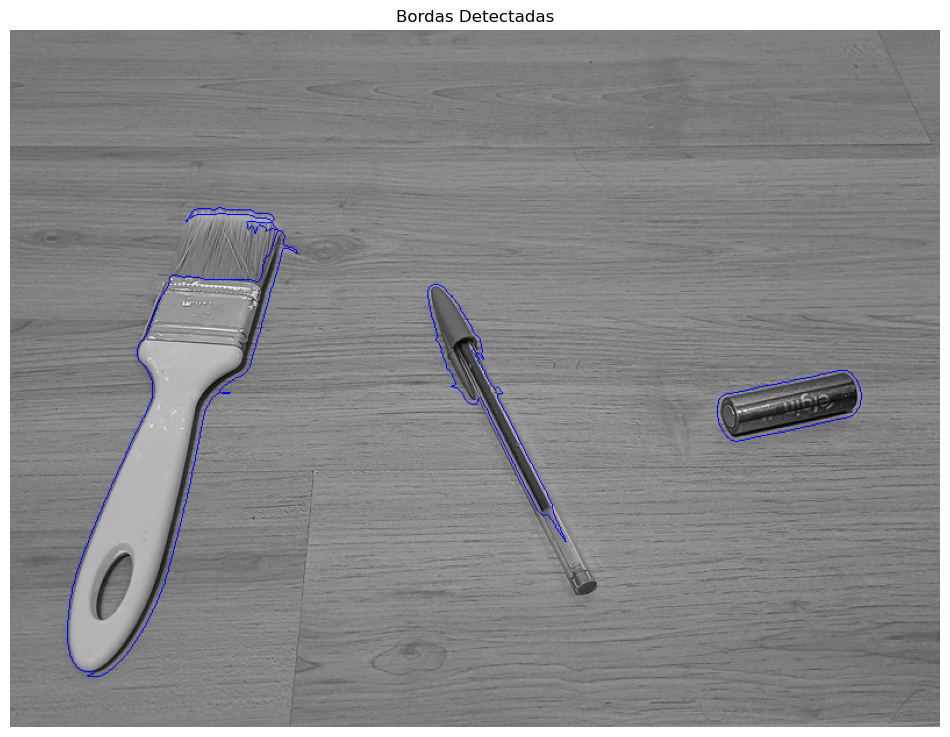

In [9]:
# Exemplo de Imagem Processada
image_path = r'.\deteccaoBorda\contrast_stretching\0111.png'
image = mpimg.imread(image_path)

# Exibir a imagem
plt.figure(figsize=(12, 10)) 
plt.imshow(image)
plt.axis('off')
plt.title('Bordas Detectadas')
plt.show()

In [10]:
# Lista para armazenar todas as áreas e propriedades
todas_areas = []
todas_props = []

# Lista para armazenar dados para o CSV
dados_csv = []

# Processar cada imagem
for imagem_path in imagens_2:
    imagem_processada, areas, props_img = processar_imagem(imagem_path)
    todas_areas.append(areas)
    todas_props.append(props_img)

    diretorio, nome_arquivo = os.path.split(imagem_path)
    nome_pasta = os.path.basename(diretorio)
    caminho_saida = os.path.join('.\\', pasta_destino, nome_pasta, nome_arquivo)
    cv2.imwrite(caminho_saida, cv2.cvtColor(imagem_processada, cv2.COLOR_BGR2RGB))
    
    # Ordenar áreas e props_img com base nas áreas dos contornos
    areas_props_sorted = sorted(zip(areas, props_img), key=lambda x: x[0], reverse=True)

    # Pegar as três maiores áreas e suas respectivas propriedades
    maiores_areas_props = areas_props_sorted[:3]

    # Garantir que tenhamos exatamente 3 entradas, preenchendo com valores vazios, se necessário
    while len(maiores_areas_props) < 3:
        maiores_areas_props.append((None, None))

    # Para cada uma das três maiores áreas, recuperar diâmetro e menor eixo
    for idx, (area, prop) in enumerate(maiores_areas_props):
        if area is not None and prop is not None:
            try:
                diameter = prop.major_axis_length  # Supondo que você queira o diâmetro
                minor_axis = prop.minor_axis_length  # Supondo que você queira o menor eixo
            except ValueError as e:
                print(f"Erro ao calcular propriedades: {e}")
                diameter = None
                minor_axis = None
        else:
            area = ''
            diameter = ''
            minor_axis = ''

        diretorio, nome_arquivo = os.path.split(imagem_path)
        
        # Adicionar os dados para o CSV
        dados_csv.append({
            'Objeto': '',  # Preencha conforme necessário
            'Classe': '',  # Preencha conforme necessário
            'n_contorno': idx,
            'Área': f'{area:.2f}'.replace('.', ',') if area not in [None, ''] else '',
            'Diâmetro': f'{diameter:.15f}'.replace('.', ',') if diameter not in [None, ''] else '',
            'Minor': f'{minor_axis:.15f}'.replace('.', ',') if minor_axis not in [None, ''] else '',
            'Diretorio': diretorio,
            'Imagem': nome_arquivo
        })

        # Imprimir os dados
        print(f"Imagem: {imagem_path} - Área: {area}, Diâmetro: {diameter}, Menor: {minor_axis}")
    
    print()
    
    # Liberar a memória das variáveis da imagem processada
    del imagem_processada
    del areas
    del props_img

Imagem: .\augmentedDataset\laplacian_img\0001.png - Área: 10829.0, Diâmetro: 9.41636653537873, Menor: 3.550442405024983
Imagem: .\augmentedDataset\laplacian_img\0001.png - Área: 755.0, Diâmetro: 5.752353900398938, Menor: 2.4598618807432486
Imagem: .\augmentedDataset\laplacian_img\0001.png - Área: 749.0, Diâmetro: 4.093338188813542, Menor: 1.563516060678838

Imagem: .\augmentedDataset\laplacian_img\0002.png - Área: 10674.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0002.png - Área: 8180.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0002.png - Área: 7801.5, Diâmetro: 9.5274387612839, Menor: 5.309382572677005

Imagem: .\augmentedDataset\laplacian_img\0003.png - Área: 9666.0, Diâmetro: 5.133805351608395, Menor: 1.5423153015346889
Imagem: .\augmentedDataset\laplacian_img\0003.png - Área: 7370.5, Diâmetro: 8.49372773570204, Menor: 1.921802238952664
Imagem: .\augmentedDataset\laplacian_img\0003.png - Á

Imagem: .\augmentedDataset\laplacian_img\0025.png - Área: 8674.5, Diâmetro: 5.529681747206153, Menor: 2.539175685738357
Imagem: .\augmentedDataset\laplacian_img\0025.png - Área: 3972.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0025.png - Área: 3500.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0026.png - Área: 9318.0, Diâmetro: 5.971098560847527, Menor: 1.8593259767334247
Imagem: .\augmentedDataset\laplacian_img\0026.png - Área: 9255.5, Diâmetro: 9.850849153622066, Menor: 1.985817190609744
Imagem: .\augmentedDataset\laplacian_img\0026.png - Área: 4303.0, Diâmetro: 7.344978793975445, Menor: 4.031288443667983

Imagem: .\augmentedDataset\laplacian_img\0027.png - Área: 26215.0, Diâmetro: 7.503608953854994, Menor: 2.560873852779435
Imagem: .\augmentedDataset\laplacian_img\0027.png - Área: 9627.0, Diâmetro: 9.361604729916602, Menor: 3.1445404526863565
Imagem: .\augmentedDataset\laplacian_img\0027.png

Imagem: .\augmentedDataset\laplacian_img\0049.png - Área: 9960.0, Diâmetro: 23.184664615257137, Menor: 3.5345055905460296
Imagem: .\augmentedDataset\laplacian_img\0049.png - Área: 8381.0, Diâmetro: 4.363338213437162, Menor: 1.65500979239906
Imagem: .\augmentedDataset\laplacian_img\0049.png - Área: 3901.0, Diâmetro: 8.163824306746362, Menor: 2.979180826158172

Imagem: .\augmentedDataset\laplacian_img\0050.png - Área: 9968.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0050.png - Área: 8065.0, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\laplacian_img\0050.png - Área: 2481.0, Diâmetro: 24.862559952341517, Menor: 2.99260243814539

Imagem: .\augmentedDataset\laplacian_img\0051.png - Área: 14864.0, Diâmetro: 6.586417573021535, Menor: 1.685623260404093
Imagem: .\augmentedDataset\laplacian_img\0051.png - Área: 11209.5, Diâmetro: 14.323107753921322, Menor: 5.507139390787102
Imagem: .\augmentedDataset\laplacian_img\0051.png - Área: 11

Imagem: .\augmentedDataset\laplacian_img\0073.png - Área: 10854.0, Diâmetro: 6.514932809935373, Menor: 3.15129346174354
Imagem: .\augmentedDataset\laplacian_img\0073.png - Área: 6612.5, Diâmetro: 24.669536194252423, Menor: 3.6042159826179496
Imagem: .\augmentedDataset\laplacian_img\0073.png - Área: 5258.0, Diâmetro: 11.872781992229013, Menor: 2.9986436034652355

Imagem: .\augmentedDataset\laplacian_img\0074.png - Área: 8856.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0074.png - Área: 4851.0, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\laplacian_img\0074.png - Área: 1170.5, Diâmetro: 14.619559763558538, Menor: 2.864606835106732

Imagem: .\augmentedDataset\laplacian_img\0075.png - Área: 9161.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0075.png - Área: 3816.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0075.png - Área: 1536.5, Diâmetro

Imagem: .\augmentedDataset\laplacian_img\0097.png - Área: 7954.0, Diâmetro: 6.040895836088439, Menor: 1.8728527698485424
Imagem: .\augmentedDataset\laplacian_img\0097.png - Área: 4038.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0097.png - Área: 3572.0, Diâmetro: 4.1204045563213505, Menor: 2.4025541184843804

Imagem: .\augmentedDataset\laplacian_img\0098.png - Área: 7744.5, Diâmetro: 24.804009770211902, Menor: 9.468050496573154
Imagem: .\augmentedDataset\laplacian_img\0098.png - Área: 4557.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0098.png - Área: 2476.5, Diâmetro: 5.321869122843981, Menor: 1.7826129808008924

Imagem: .\augmentedDataset\laplacian_img\0099.png - Área: 7932.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0099.png - Área: 5767.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0099.png - Área: 4678.5, Diâmetro: 9.030588094529637, Menor: 4

Imagem: .\augmentedDataset\laplacian_img\0121.png - Área: 31794.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0121.png - Área: 13256.0, Diâmetro: 7.301306552276451, Menor: 3.1465535388572135
Imagem: .\augmentedDataset\laplacian_img\0121.png - Área: 6651.5, Diâmetro: 10.043864236141385, Menor: 7.09173224296857

Imagem: .\augmentedDataset\laplacian_img\0122.png - Área: 40706.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0122.png - Área: 15462.5, Diâmetro: 15.058965688401813, Menor: 6.276371694835742
Imagem: .\augmentedDataset\laplacian_img\0122.png - Área: 11565.0, Diâmetro: 9.04549897752179, Menor: 2.976640504136427

Imagem: .\augmentedDataset\laplacian_img\0123.png - Área: 31036.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0123.png - Área: 4294.5, Diâmetro: 10.867407719113874, Menor: 2.8252600047859957
Imagem: .\augmentedDataset\laplacian_img\0123.png - Área: 4182.5, Diâmetro: 6.02549

Imagem: .\augmentedDataset\laplacian_img\0146.png - Área: 99346.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0146.png - Área: 23706.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0146.png - Área: 5885.5, Diâmetro: 12.17648557172933, Menor: 4.055829435448354

Imagem: .\augmentedDataset\laplacian_img\0147.png - Área: 49338.0, Diâmetro: 9.933548452268264, Menor: 2.822984811438478
Imagem: .\augmentedDataset\laplacian_img\0147.png - Área: 5066.5, Diâmetro: 4.0, Menor: 1.3856406460551018
Imagem: .\augmentedDataset\laplacian_img\0147.png - Área: 3219.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0148.png - Área: 318229.5, Diâmetro: 7.32384322019635, Menor: 1.9903066311460553
Imagem: .\augmentedDataset\laplacian_img\0148.png - Área: 4064.0, Diâmetro: 9.435177521958435, Menor: 3.761778681440278
Imagem: .\augmentedDataset\laplacian_img\0148.png - Área: 3827.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .

Imagem: .\augmentedDataset\laplacian_img\0170.png - Área: 125599.0, Diâmetro: 5.798675975401699, Menor: 1.679226422119302
Imagem: .\augmentedDataset\laplacian_img\0170.png - Área: 6814.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0170.png - Área: 2251.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0171.png - Área: 32823.5, Diâmetro: 8.784027024746536, Menor: 5.112508604249241
Imagem: .\augmentedDataset\laplacian_img\0171.png - Área: 14433.5, Diâmetro: 9.8487914655752, Menor: 3.175159693241494
Imagem: .\augmentedDataset\laplacian_img\0171.png - Área: 4365.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\laplacian_img\0172.png - Área: 268420.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0172.png - Área: 16248.0, Diâmetro: 6.810646416042492, Menor: 3.0500156385906534
Imagem: .\augmentedDataset\laplacian_img\0172.png - Área: 3353.0, Diâmetro: 3.7032803990902057, Menor: 

Imagem: .\augmentedDataset\laplacian_img\0195.png - Área: 298814.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0195.png - Área: 6061.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\laplacian_img\0195.png - Área: 3218.0, Diâmetro: 19.249808703110794, Menor: 12.754788828143719

Imagem: .\augmentedDataset\laplacian_img\0196.png - Área: 179457.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0196.png - Área: 6144.5, Diâmetro: 3.885753375057407, Menor: 2.7954428906961324
Imagem: .\augmentedDataset\laplacian_img\0196.png - Área: 4663.5, Diâmetro: 5.444424563872507, Menor: 2.253495322449476

Imagem: .\augmentedDataset\laplacian_img\0197.png - Área: 2537.0, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\augmentedDataset\laplacian_img\0197.png - Área: 1585.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\laplacian_img\0197.png - Área: 1462.5, Diâmetro: 5.656854249492381, Menor: 2.0

Imagem: .\augmentedDa

Imagem: .\augmentedDataset\laplacian_img\0220.png - Área: 11482.0, Diâmetro: 14.995535469760526, Menor: 12.259470951328328
Imagem: .\augmentedDataset\laplacian_img\0220.png - Área: 5791.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0220.png - Área: 3981.0, Diâmetro: 6.468355765954826, Menor: 2.2470564242866353

Imagem: .\augmentedDataset\laplacian_img\0221.png - Área: 14099.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0221.png - Área: 4113.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\laplacian_img\0221.png - Área: 1983.0, Diâmetro: 14.45310338557175, Menor: 6.475784110180358

Imagem: .\augmentedDataset\laplacian_img\0222.png - Área: 11407.5, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087
Imagem: .\augmentedDataset\laplacian_img\0222.png - Área: 3255.0, Diâmetro: 15.43054010196103, Menor: 3.701980623325151
Imagem: .\augmentedDataset\laplacian_img\0222.png - Área: 2067.5, Diâmetro: 30.9524886

Imagem: .\augmentedDataset\laplacian_img\0247.png - Área: 258.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\laplacian_img\0247.png - Área: 80.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0247.png - Área: 65.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0248.png - Área: 109.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0248.png - Área: 75.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0248.png - Área: 49.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0249.png - Área: 75.5, Diâmetro: 4.34169545110285, Menor: 1.2765894445250696
Imagem: .\augmentedDataset\laplacian_img\0249.png - Área: 58.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0249.png - Área: 54.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0250.png - Área: 170.5, Diâmetro: 3.9999999999

Imagem: .\augmentedDataset\laplacian_img\0275.png - Área: 128.5, Diâmetro: 5.00274675656753, Menor: 1.4434805162398887
Imagem: .\augmentedDataset\laplacian_img\0275.png - Área: 89.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0275.png - Área: 71.0, Diâmetro: 4.796702691401646, Menor: 1.7646790841090736

Imagem: .\augmentedDataset\laplacian_img\0276.png - Área: 296.5, Diâmetro: 6.76415936929849, Menor: 2.8654223193364645
Imagem: .\augmentedDataset\laplacian_img\0276.png - Área: 103.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0276.png - Área: 63.0, Diâmetro: 8.88510257365877, Menor: 8.7401980363272

Imagem: .\augmentedDataset\laplacian_img\0277.png - Área: 78.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\laplacian_img\0277.png - Área: 66.5, Diâmetro: 8.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0277.png - Área: 64.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0278

Imagem: .\augmentedDataset\laplacian_img\0304.png - Área: 110.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0304.png - Área: 73.5, Diâmetro: 6.435761594135788, Menor: 2.1956713559744716
Imagem: .\augmentedDataset\laplacian_img\0304.png - Área: 69.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0305.png - Área: 104.0, Diâmetro: 9.211247838937892, Menor: 8.76820649309867
Imagem: .\augmentedDataset\laplacian_img\0305.png - Área: 56.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0305.png - Área: 44.0, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951

Imagem: .\augmentedDataset\laplacian_img\0306.png - Área: 152.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0306.png - Área: 102.0, Diâmetro: 5.416025603090641, Menor: 2.96273147243853
Imagem: .\augmentedDataset\laplacian_img\0306.png - Área: 74.0, Diâmetro: 6.728750347642659, Menor: 2.4665601065246308

Imagem: .\augmentedDataset\laplacian_img\

Imagem: .\augmentedDataset\laplacian_img\0331.png - Área: 149.5, Diâmetro: 4.363338213437162, Menor: 1.65500979239906
Imagem: .\augmentedDataset\laplacian_img\0331.png - Área: 64.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0331.png - Área: 51.5, Diâmetro: 4.796702691401646, Menor: 1.7646790841090736

Imagem: .\augmentedDataset\laplacian_img\0332.png - Área: 134.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\augmentedDataset\laplacian_img\0332.png - Área: 38.5, Diâmetro: 12.871487150572738, Menor: 2.9837218889197232
Imagem: .\augmentedDataset\laplacian_img\0332.png - Área: 28.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0333.png - Área: 44.5, Diâmetro: 13.404941625952386, Menor: 2.961378433606764
Imagem: .\augmentedDataset\laplacian_img\0333.png - Área: 38.0, Diâmetro: 15.271418102210138, Menor: 3.234572538620719
Imagem: .\augmentedDataset\laplacian_img\0333.png - Área: 9.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\au

Imagem: .\augmentedDataset\laplacian_img\0358.png - Área: 929.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\laplacian_img\0358.png - Área: 123.0, Diâmetro: 10.514705541163824, Menor: 1.634544772524753
Imagem: .\augmentedDataset\laplacian_img\0358.png - Área: 81.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0359.png - Área: 851.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\laplacian_img\0359.png - Área: 73.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0359.png - Área: 66.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\laplacian_img\0360.png - Área: 66.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0360.png - Área: 55.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0360.png - Área: 47.0, Diâmetro: 9.699658438572742, Menor: 7.461007048316239

Imagem: .\augmentedDataset\la

Imagem: .\augmentedDataset\laplacian_img\0384.png - Área: 3497.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0384.png - Área: 758.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0384.png - Área: 96.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0385.png - Área: 3592.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0385.png - Área: 704.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\laplacian_img\0385.png - Área: 384.5, Diâmetro: 11.584016511937351, Menor: 4.929539265441568

Imagem: .\augmentedDataset\laplacian_img\0386.png - Área: 3663.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\laplacian_img\0386.png - Área: 752.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0386.png - Área: 193.0, Diâmetro: 3.265986323710904, Menor: 0.0

Im

Imagem: .\augmentedDataset\laplacian_img\0411.png - Área: 761.5, Diâmetro: 8.150049730330068, Menor: 1.8315204533186535
Imagem: .\augmentedDataset\laplacian_img\0411.png - Área: 412.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\laplacian_img\0411.png - Área: 98.0, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0412.png - Área: 2806.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0412.png - Área: 73.0, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\augmentedDataset\laplacian_img\0412.png - Área: 59.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0413.png - Área: 57.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0413.png - Área: 47.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0413.png - Área: 3.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\041

Imagem: .\augmentedDataset\laplacian_img\0439.png - Área: 1812.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0439.png - Área: 799.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0439.png - Área: 551.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0440.png - Área: 86.5, Diâmetro: 4.34169545110285, Menor: 1.27658944452507
Imagem: .\augmentedDataset\laplacian_img\0440.png - Área: 73.5, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0440.png - Área: 44.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0441.png - Área: 1002.5, Diâmetro: 6.179643692704902, Menor: 2.728578370853051
Imagem: .\augmentedDataset\laplacian_img\0441.png - Área: 334.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0441.png - Área: 14.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737

Imagem: .\augmentedDataset\laplacian_img\0442.png - Área: 18.5, Diâme

Imagem: .\augmentedDataset\laplacian_img\0468.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0468.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0468.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\laplacian_img\0469.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0469.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0469.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\laplacian_img\0470.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0470.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\laplacian_img\0470.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\laplacian_img\0471.png - Área: 39.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0471.png - Área: 37.0, Diâmetro: 2.0, Menor: 2.0
Imagem: .\augmentedDataset\laplacian_img\0471.png - Área: 7.0, Diâme

Imagem: .\augmentedDataset\laplacian_img\0496.png - Área: 14928.0, Diâmetro: 5.656854249492381, Menor: 1.3997084244475302
Imagem: .\augmentedDataset\laplacian_img\0496.png - Área: 386.0, Diâmetro: 10.490902329500843, Menor: 3.834934597405998
Imagem: .\augmentedDataset\laplacian_img\0496.png - Área: 197.5, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641265

Imagem: .\augmentedDataset\laplacian_img\0497.png - Área: 327.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0497.png - Área: 187.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0497.png - Área: 181.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0498.png - Área: 165.5, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306
Imagem: .\augmentedDataset\laplacian_img\0498.png - Área: 157.0, Diâmetro: 3.651483716701107, Menor: 2.1081851067789197
Imagem: .\augmentedDataset\laplacian_img\0498.png - Área: 156.5, Diâmetro: 4.0, Menor: 1.385

Imagem: .\augmentedDataset\laplacian_img\0523.png - Área: 14770.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\laplacian_img\0523.png - Área: 1789.5, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306
Imagem: .\augmentedDataset\laplacian_img\0523.png - Área: 199.5, Diâmetro: 33.868663584068734, Menor: 6.598434051816422

Imagem: .\augmentedDataset\laplacian_img\0524.png - Área: 17464.0, Diâmetro: 11.418523942776968, Menor: 3.201545131623556
Imagem: .\augmentedDataset\laplacian_img\0524.png - Área: 215.5, Diâmetro: 8.115245610111074, Menor: 4.5236905665500515
Imagem: .\augmentedDataset\laplacian_img\0524.png - Área: 101.0, Diâmetro: 5.274258481434536, Menor: 1.946056459258261

Imagem: .\augmentedDataset\laplacian_img\0525.png - Área: 250.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0525.png - Área: 218.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0525.png - Área: 194.0, Diâmetro: 3.

Imagem: .\augmentedDataset\laplacian_img\0549.png - Área: 7935.0, Diâmetro: 5.444424563872507, Menor: 2.253495322449476
Imagem: .\augmentedDataset\laplacian_img\0549.png - Área: 2952.0, Diâmetro: 4.743365517193277, Menor: 1.3492529674978493
Imagem: .\augmentedDataset\laplacian_img\0549.png - Área: 812.0, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306

Imagem: .\augmentedDataset\laplacian_img\0550.png - Área: 9235.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0550.png - Área: 204.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0550.png - Área: 159.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0551.png - Área: 4604.0, Diâmetro: 6.0, Menor: 1.959591794226542
Imagem: .\augmentedDataset\laplacian_img\0551.png - Área: 1244.5, Diâmetro: 6.606921481990292, Menor: 3.411528888814744
Imagem: .\augmentedDataset\laplacian_img\0551.png - Área: 1199.

Imagem: .\augmentedDataset\laplacian_img\0575.png - Área: 7418.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\laplacian_img\0575.png - Área: 7014.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0575.png - Área: 5464.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\laplacian_img\0576.png - Área: 6674.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\laplacian_img\0576.png - Área: 5442.5, Diâmetro: 6.379043545017158, Menor: 3.278002966864877
Imagem: .\augmentedDataset\laplacian_img\0576.png - Área: 5168.0, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\laplacian_img\0577.png - Área: 7060.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0577.png - Área: 5819.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\laplacian_img\0577.png - Área: 5355.0, Diâmetro: 4.0, Menor: 1.3856406460551023

Imagem: .\augmentedDataset\laplacian_

Imagem: .\augmentedDataset\log_transform\0001.png - Área: 8.5, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\log_transform\0001.png - Área: 4.5, Diâmetro: 7.141921394560869, Menor: 1.9130147570210732
Imagem: .\augmentedDataset\log_transform\0001.png - Área: 4.0, Diâmetro: 7.4062343186343895, Menor: 1.8952935556073236

Imagem: .\augmentedDataset\log_transform\0002.png - Área: 26.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0002.png - Área: 7.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0002.png - Área: 5.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0003.png - Área: 102.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0003.png - Área: 15.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0003.png - Área: 15.0, Diâmetro: 8.693970686258778, Menor: 4.063022541178171

Imagem: .\augmentedDataset\log_transform\0004.png - Área: 15

Imagem: .\augmentedDataset\log_transform\0030.png - Área: 1579.5, Diâmetro: 17.812724763287726, Menor: 1.4922588607062521
Imagem: .\augmentedDataset\log_transform\0030.png - Área: 31.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0030.png - Área: 7.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\log_transform\0031.png - Área: 461.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0031.png - Área: 7.0, Diâmetro: 5.672452304781605, Menor: 1.5606183863895253
Imagem: .\augmentedDataset\log_transform\0031.png - Área: 4.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0032.png - Área: 2.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0032.png - Área: 0.0, Diâmetro: 4.972652484064487, Menor: 2.7453943400984544
Imagem: .\augmentedDataset\log_transform\0032.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0033.png - Área: 32

Imagem: .\augmentedDataset\log_transform\0060.png - Área: 358.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0060.png - Área: 91.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0060.png - Área: 5.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0061.png - Área: 297.5, Diâmetro: 10.508125960396756, Menor: 1.4986512159613496
Imagem: .\augmentedDataset\log_transform\0061.png - Área: 12.0, Diâmetro: 4.363338213437162, Menor: 1.65500979239906
Imagem: .\augmentedDataset\log_transform\0061.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0062.png - Área: 385.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0062.png - Área: 136.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0062.png - Área: 115.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0063.png - Área: 1.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_tr

Imagem: .\augmentedDataset\log_transform\0089.png - Área: 2236.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0089.png - Área: 17.0, Diâmetro: 5.773516346683699, Menor: 4.155548714567498
Imagem: .\augmentedDataset\log_transform\0089.png - Área: 0.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317

Imagem: .\augmentedDataset\log_transform\0090.png - Área: 2189.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0090.png - Área: 92.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0090.png - Área: 8.5, Diâmetro: 4.993927366567251, Menor: 1.772659614960501

Imagem: .\augmentedDataset\log_transform\0091.png - Área: 3.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0091.png - Área: 1.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\log_transform\0091.png - Área: 1.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\log_t

Imagem: .\augmentedDataset\log_transform\0117.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0117.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0117.png - Área: 0.0, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0118.png - Área: 2.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0118.png - Área: 0.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0118.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0119.png - Área: 7.0, Diâmetro: 6.34001103350453, Menor: 0.874219706390114
Imagem: .\augmentedDataset\log_transform\0119.png - Área: 5.0, Diâmetro: 5.912809357935427, Menor: 0.9373822575189021
Imagem: .\augmentedDataset\log_transform\0119.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0120.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0120.png -

Imagem: .\augmentedDataset\log_transform\0142.png - Área: 34992.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\log_transform\0142.png - Área: 29676.0, Diâmetro: 8.753629194559734, Menor: 4.664353990251352
Imagem: .\augmentedDataset\log_transform\0142.png - Área: 3052.0, Diâmetro: 15.65290693056972, Menor: 3.341225814200827

Imagem: .\augmentedDataset\log_transform\0143.png - Área: 31020.0, Diâmetro: 10.848626017585756, Menor: 4.3334966040433835
Imagem: .\augmentedDataset\log_transform\0143.png - Área: 5746.5, Diâmetro: 15.319814814915198, Menor: 7.739458356560774
Imagem: .\augmentedDataset\log_transform\0143.png - Área: 5207.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0144.png - Área: 31127.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0144.png - Área: 5356.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\log_transform\0144.png - Área: 4299.0, Diâmetro: 9.022140

Imagem: .\augmentedDataset\log_transform\0166.png - Área: 15913.5, Diâmetro: 6.689596662859233, Menor: 2.8056226956746744
Imagem: .\augmentedDataset\log_transform\0166.png - Área: 9923.0, Diâmetro: 4.34169545110285, Menor: 1.27658944452507
Imagem: .\augmentedDataset\log_transform\0166.png - Área: 3887.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0167.png - Área: 15954.5, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452
Imagem: .\augmentedDataset\log_transform\0167.png - Área: 9808.5, Diâmetro: 9.398026701097182, Menor: 3.8559736628822265
Imagem: .\augmentedDataset\log_transform\0167.png - Área: 3676.0, Diâmetro: 14.730031707332811, Menor: 3.69494204314745

Imagem: .\augmentedDataset\log_transform\0168.png - Área: 15910.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\log_transform\0168.png - Área: 9786.0, Diâmetro: 3.885753375057407, Menor: 2.7954428906961324
Imagem: .\augmentedDataset\log_transform\0168.

Imagem: .\augmentedDataset\log_transform\0191.png - Área: 6453.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0191.png - Área: 3231.0, Diâmetro: 11.378608858399533, Menor: 4.4588824352246155
Imagem: .\augmentedDataset\log_transform\0191.png - Área: 2004.5, Diâmetro: 5.196736578748781, Menor: 2.5652886368981065

Imagem: .\augmentedDataset\log_transform\0192.png - Área: 33596.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0192.png - Área: 11971.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0192.png - Área: 7030.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\augmentedDataset\log_transform\0193.png - Área: 46961.0, Diâmetro: 5.529681747206153, Menor: 2.539175685738357
Imagem: .\augmentedDataset\log_transform\0193.png - Área: 5068.5, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772
Imagem: .\augmentedDataset\log_transform\0193.png - Área: 5030.5, Diâmetro: 2.8284271247461903, Menor: 0.0

Image

Imagem: .\augmentedDataset\log_transform\0216.png - Área: 10440.0, Diâmetro: 16.929393779783485, Menor: 4.2871920410746664
Imagem: .\augmentedDataset\log_transform\0216.png - Área: 1589.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0216.png - Área: 1413.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0217.png - Área: 10537.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\log_transform\0217.png - Área: 4541.5, Diâmetro: 15.144226990334577, Menor: 5.433979067883142
Imagem: .\augmentedDataset\log_transform\0217.png - Área: 1648.5, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0218.png - Área: 10468.5, Diâmetro: 7.69964040311149, Menor: 3.5531443419775863
Imagem: .\augmentedDataset\log_transform\0218.png - Área: 3825.5, Diâmetro: 16.664834737344012, Menor: 3.0015071130792648
Imagem: .\augmentedDataset\log_transform\0218.png - Área: 2308.0, Diâmetro: 4.77795383588526, Menor: 3.9819092890

Imagem: .\augmentedDataset\log_transform\0244.png - Área: 5795.5, Diâmetro: 7.862465364827691, Menor: 1.7267421309752562
Imagem: .\augmentedDataset\log_transform\0244.png - Área: 4229.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0244.png - Área: 770.5, Diâmetro: 5.77331086475517, Menor: 1.1085493488789315

Imagem: .\augmentedDataset\log_transform\0245.png - Área: 58.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0245.png - Área: 34.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0245.png - Área: 27.5, Diâmetro: 3.265986323710904, Menor: 2.0

Imagem: .\augmentedDataset\log_transform\0246.png - Área: 30.5, Diâmetro: 6.17981113601935, Menor: 1.1685417744722666
Imagem: .\augmentedDataset\log_transform\0246.png - Área: 27.0, Diâmetro: 7.196290907113706, Menor: 2.6899106681105263
Imagem: .\augmentedDataset\log_transform\0246.png - Área: 15.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0247.png - Ár

Imagem: .\augmentedDataset\log_transform\0273.png - Área: 633.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0273.png - Área: 41.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0273.png - Área: 0.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333

Imagem: .\augmentedDataset\log_transform\0274.png - Área: 35.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\log_transform\0274.png - Área: 27.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\log_transform\0274.png - Área: 8.5, Diâmetro: 4.320493798938573, Menor: 1.8856180831641272

Imagem: .\augmentedDataset\log_transform\0275.png - Área: 82.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\log_transform\0275.png - Área: 43.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0275.png - Área: 14.0, Diâmetro: 2.8284271247461903, Menor: 0.0

Imagem: .\augmentedDataset\l

Imagem: .\augmentedDataset\log_transform\0301.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0301.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0301.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0302.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0302.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0302.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0303.png - Área: 1.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0303.png - Área: 1.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0303.png - Área: 0.0, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772

Imagem: .\augmentedDataset\log_transform\0304.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0304.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0304.png - Área: , 

Imagem: .\augmentedDataset\log_transform\0329.png - Área: 310.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0329.png - Área: 160.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0329.png - Área: 129.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0330.png - Área: 271.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0330.png - Área: 45.5, Diâmetro: 3.9999999999999996, Menor: 1.632993161855452
Imagem: .\augmentedDataset\log_transform\0330.png - Área: 41.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0331.png - Área: 653.5, Diâmetro: 10.986838693671382, Menor: 4.139751053451332
Imagem: .\augmentedDataset\log_transform\0331.png - Área: 83.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0331.png - Área: 38.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0332.png - Área: 73.5, Diâmetro: 9.554499602971273, Meno

Imagem: .\augmentedDataset\log_transform\0357.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0357.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0357.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0358.png - Área: 747.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\log_transform\0358.png - Área: 7.0, Diâmetro: 8.957771907609729, Menor: 1.239395106096407
Imagem: .\augmentedDataset\log_transform\0358.png - Área: 0.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0359.png - Área: 729.5, Diâmetro: 43.7942324124635, Menor: 13.058841879072839
Imagem: .\augmentedDataset\log_transform\0359.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0359.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0360.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0360.png - Área: , Diâmetro: ,

Imagem: .\augmentedDataset\log_transform\0387.png - Área: 49.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0387.png - Área: 21.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0387.png - Área: 11.0, Diâmetro: 9.626212040309262, Menor: 1.5945699499403978

Imagem: .\augmentedDataset\log_transform\0388.png - Área: 90.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\log_transform\0388.png - Área: 43.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\log_transform\0388.png - Área: 22.0, Diâmetro: 6.273719102168027, Menor: 2.615651364200643

Imagem: .\augmentedDataset\log_transform\0389.png - Área: 207.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0389.png - Área: 79.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0389.png - Área: 10.5, Diâmetro: 6.1893197474954444, Menor: 1.4771990325038336

Imagem: .\augmentedDataset\log_transform\03

Imagem: .\augmentedDataset\log_transform\0417.png - Área: 21.0, Diâmetro: 13.954048025479429, Menor: 1.818576212198744
Imagem: .\augmentedDataset\log_transform\0417.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0417.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0418.png - Área: 242.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0418.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0418.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0419.png - Área: 12.0, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0419.png - Área: 6.0, Diâmetro: 3.265986323710904, Menor: 2.0
Imagem: .\augmentedDataset\log_transform\0419.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0420.png - Área: 47.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0420.png - Área: 40.5, Diâmetro: 2.30940107675850

Imagem: .\augmentedDataset\log_transform\0446.png - Área: 136.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0446.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0446.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0447.png - Área: 9.0, Diâmetro: 7.272563765941617, Menor: 3.073909012370703
Imagem: .\augmentedDataset\log_transform\0447.png - Área: 7.0, Diâmetro: 5.670233719167884, Menor: 2.0479571729792667
Imagem: .\augmentedDataset\log_transform\0447.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0448.png - Área: 61.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0448.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0448.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0449.png - Área: 346.0, Diâmetro: 19.41432739846221, Menor: 1.4661689201820307
Imagem: .\augmentedDataset\log_transform\0449.png - Área: 203

Imagem: .\augmentedDataset\log_transform\0478.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0478.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0478.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0479.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0479.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0479.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0480.png - Área: 36.5, Diâmetro: 5.577318563820872, Menor: 2.942249351623098
Imagem: .\augmentedDataset\log_transform\0480.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\log_transform\0480.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\log_transform\0481.png - Área: 9938.0, Diâmetro: 8.780369033564831, Menor: 8.156048040222409
Imagem: .\augmentedDataset\log_transform\0481.png - Área: 176.0, Diâmetro: 10.988967196041042, Menor: 4.134884671258765

Imagem: .\augmentedDataset\log_transform\0504.png - Área: 186.5, Diâmetro: 13.878666400667898, Menor: 10.146871824747807
Imagem: .\augmentedDataset\log_transform\0504.png - Área: 157.0, Diâmetro: 40.793575440748675, Menor: 6.43617657968869
Imagem: .\augmentedDataset\log_transform\0504.png - Área: 80.0, Diâmetro: 7.835357692057425, Menor: 3.7573093989115685

Imagem: .\augmentedDataset\log_transform\0505.png - Área: 9403.0, Diâmetro: 14.318262913906196, Menor: 7.813340448010266
Imagem: .\augmentedDataset\log_transform\0505.png - Área: 165.5, Diâmetro: 4.7271453337587435, Menor: 2.1573356237551296
Imagem: .\augmentedDataset\log_transform\0505.png - Área: 135.5, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\augmentedDataset\log_transform\0506.png - Área: 2207.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\log_transform\0506.png - Área: 927.5, Diâmetro: 4.47213595499958, Menor: 2.0
Imagem: .\augmentedDataset\log_transform\0506.png -

Imagem: .\augmentedDataset\log_transform\0530.png - Área: 1112.0, Diâmetro: 19.62375126937597, Menor: 1.703180754057548
Imagem: .\augmentedDataset\log_transform\0530.png - Área: 54.5, Diâmetro: 5.23606797749979, Menor: 0.7639320225002099
Imagem: .\augmentedDataset\log_transform\0530.png - Área: 48.5, Diâmetro: 6.898678167604479, Menor: 1.9769267917192352

Imagem: .\augmentedDataset\log_transform\0531.png - Área: 2792.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\log_transform\0531.png - Área: 670.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0531.png - Área: 325.0, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\log_transform\0532.png - Área: 8809.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0532.png - Área: 363.0, Diâmetro: 6.8428891463926025, Menor: 6.314062789187765
Imagem: .\augmentedDataset\log_transform\0532.png - Área: 122.0, Diâmetro: 21.87130138178984, Menor: 10.200381775392934

Image

Imagem: .\augmentedDataset\log_transform\0557.png - Área: 2283.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0557.png - Área: 451.5, Diâmetro: 3.4641016151377544, Menor: 1.4142135623730951
Imagem: .\augmentedDataset\log_transform\0557.png - Área: 317.0, Diâmetro: 6.453653545640349, Menor: 2.825935503227082

Imagem: .\augmentedDataset\log_transform\0558.png - Área: 2279.0, Diâmetro: 8.896129023137824, Menor: 2.8274763439694794
Imagem: .\augmentedDataset\log_transform\0558.png - Área: 389.5, Diâmetro: 13.572780203268286, Menor: 2.547622687020467
Imagem: .\augmentedDataset\log_transform\0558.png - Área: 314.5, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772

Imagem: .\augmentedDataset\log_transform\0559.png - Área: 957.5, Diâmetro: 8.09473590984606, Menor: 1.8434553080901188
Imagem: .\augmentedDataset\log_transform\0559.png - Área: 502.0, Diâmetro: 5.547001962252291, Menor: 2.935197542821372
Imagem: .\augmentedDataset\log_transform\0559.png - Área: 364.5, D

Imagem: .\augmentedDataset\log_transform\0582.png - Área: 9892.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0582.png - Área: 8986.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0582.png - Área: 5948.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0583.png - Área: 1267.5, Diâmetro: 5.133805351608395, Menor: 1.5423153015346889
Imagem: .\augmentedDataset\log_transform\0583.png - Área: 453.0, Diâmetro: 7.538645151328629, Menor: 3.1203734579241065
Imagem: .\augmentedDataset\log_transform\0583.png - Área: 140.0, Diâmetro: 3.677088528342677, Menor: 0.8374020402130087

Imagem: .\augmentedDataset\log_transform\0584.png - Área: 1166.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0584.png - Área: 793.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\log_transform\0584.png - Área: 640.0, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\log_transform\0585.png - Área: 2970.0, Diâmetr

Imagem: .\augmentedDataset\mean_img\0009.png - Área: 102.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0009.png - Área: 25.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0009.png - Área: 9.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0010.png - Área: 391.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0010.png - Área: 270.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898
Imagem: .\augmentedDataset\mean_img\0010.png - Área: 100.0, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\mean_img\0011.png - Área: 409.0, Diâmetro: 4.47213595499958, Menor: 2.0
Imagem: .\augmentedDataset\mean_img\0011.png - Área: 276.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0011.png - Área: 152.5, Diâmetro: 7.141921394560869, Menor: 1.9130147570210732

Imagem: .\augmentedDataset\mean_img\0012.png - Área: 758.0, Diâmetro: 3

Imagem: .\augmentedDataset\mean_img\0038.png - Área: 9515.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0038.png - Área: 9090.0, Diâmetro: 7.388385161462391, Menor: 2.9199232108213784
Imagem: .\augmentedDataset\mean_img\0038.png - Área: 5845.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0039.png - Área: 9345.5, Diâmetro: 7.06668652666286, Menor: 3.614130813056109
Imagem: .\augmentedDataset\mean_img\0039.png - Área: 9062.5, Diâmetro: 24.682398091338793, Menor: 3.5621343071773395
Imagem: .\augmentedDataset\mean_img\0039.png - Área: 72.5, Diâmetro: 9.092522307334178, Menor: 2.552163413778657

Imagem: .\augmentedDataset\mean_img\0040.png - Área: 9535.5, Diâmetro: 6.733003292241386, Menor: 4.73462423711393
Imagem: .\augmentedDataset\mean_img\0040.png - Área: 9141.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0040.png - Área: 7417.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0041.png - Á

Imagem: .\augmentedDataset\mean_img\0067.png - Área: 89.5, Diâmetro: 17.281975195754296, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0067.png - Área: 40.0, Diâmetro: 5.672452304781605, Menor: 1.5606183863895253
Imagem: .\augmentedDataset\mean_img\0067.png - Área: 17.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0068.png - Área: 86.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0068.png - Área: 59.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0068.png - Área: 35.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0069.png - Área: 31.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0069.png - Área: 23.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0069.png - Área: 12.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0070.png - Área: 89.5, Diâmetro: 5.274258481434536, Menor: 1.946056459258261
Imagem: .\augmentedDataset\mean

Imagem: .\augmentedDataset\mean_img\0095.png - Área: 6781.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0095.png - Área: 3821.0, Diâmetro: 9.16515138991168, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0095.png - Área: 463.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0096.png - Área: 524.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0096.png - Área: 68.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0096.png - Área: 55.5, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0097.png - Área: 515.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0097.png - Área: 34.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0097.png - Área: 18.5, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0098.png - Área: 6167.5, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0098.png - Área: 4182

Imagem: .\augmentedDataset\mean_img\0123.png - Área: 29579.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0123.png - Área: 14606.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0123.png - Área: 3352.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0124.png - Área: 29084.5, Diâmetro: 9.979402090502893, Menor: 1.8768710736695817
Imagem: .\augmentedDataset\mean_img\0124.png - Área: 13488.5, Diâmetro: 12.183507978600996, Menor: 2.913783337066406
Imagem: .\augmentedDataset\mean_img\0124.png - Área: 7847.0, Diâmetro: 7.252652857171122, Menor: 3.133493197660931

Imagem: .\augmentedDataset\mean_img\0125.png - Área: 29712.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0125.png - Área: 14006.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0125.png - Área: 6468.0, Diâmetro: 4.277662731533559, Menor: 2.643019518000728

Imagem:

Imagem: .\augmentedDataset\mean_img\0148.png - Área: 36235.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0148.png - Área: 30043.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0148.png - Área: 4737.5, Diâmetro: 9.586141273967433, Menor: 6.517499236822688

Imagem: .\augmentedDataset\mean_img\0149.png - Área: 36006.0, Diâmetro: 8.688601080299366, Menor: 4.106685307722791
Imagem: .\augmentedDataset\mean_img\0149.png - Área: 29970.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0149.png - Área: 1761.0, Diâmetro: 11.144824311512684, Menor: 4.39306998635601

Imagem: .\augmentedDataset\mean_img\0150.png - Área: 29990.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0150.png - Área: 1809.5, Diâmetro: 12.212688948620288, Menor: 2.392960865141579
Imagem: .\augmentedDataset\mean_img\0150.png - Área: 735.0, Diâmetro: 10.60088767129964, Menor: 3.3183975497126372

Imagem: .\augmentedDataset\mean_img\015

Imagem: .\augmentedDataset\mean_img\0173.png - Área: 16289.5, Diâmetro: 3.7032803990902057, Menor: 2.138089935299395
Imagem: .\augmentedDataset\mean_img\0173.png - Área: 14309.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0173.png - Área: 2764.0, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772

Imagem: .\augmentedDataset\mean_img\0174.png - Área: 16342.5, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0174.png - Área: 14660.0, Diâmetro: 8.137700948988831, Menor: 4.099684019975546
Imagem: .\augmentedDataset\mean_img\0174.png - Área: 4826.0, Diâmetro: 7.868484191905127, Menor: 3.7502362874517967

Imagem: .\augmentedDataset\mean_img\0175.png - Área: 36019.5, Diâmetro: 9.641717526337095, Menor: 4.290164434399711
Imagem: .\augmentedDataset\mean_img\0175.png - Área: 14802.0, Diâmetro: 9.954592414483452, Menor: 7.5103987817897195
Imagem: .\augmentedDataset\mean_img\0175.png - Área: 4858.0, Diâ

Imagem: .\augmentedDataset\mean_img\0198.png - Área: 36458.0, Diâmetro: 11.671970028268827, Menor: 4.26363180008414
Imagem: .\augmentedDataset\mean_img\0198.png - Área: 1516.5, Diâmetro: 8.691865039935566, Menor: 3.0152084716559684
Imagem: .\augmentedDataset\mean_img\0198.png - Área: 1295.0, Diâmetro: 4.610834905547121, Menor: 3.0688576741519786

Imagem: .\augmentedDataset\mean_img\0199.png - Área: 36647.5, Diâmetro: 10.019817311530087, Menor: 3.713076152322998
Imagem: .\augmentedDataset\mean_img\0199.png - Área: 4067.0, Diâmetro: 8.875025725111195, Menor: 2.9936281557797195
Imagem: .\augmentedDataset\mean_img\0199.png - Área: 1429.5, Diâmetro: 2.0, Menor: 2.0

Imagem: .\augmentedDataset\mean_img\0200.png - Área: 8295.0, Diâmetro: 7.7076469595903605, Menor: 3.761626549904823
Imagem: .\augmentedDataset\mean_img\0200.png - Área: 5518.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0200.png - Área: 5074.0, Diâmetro: 4.988876515698589, Menor: 2

Imagem: .\augmentedDataset\mean_img\0223.png - Área: 35474.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0223.png - Área: 2588.0, Diâmetro: 5.54896316106684, Menor: 3.057943699848417
Imagem: .\augmentedDataset\mean_img\0223.png - Área: 696.0, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0224.png - Área: 35462.0, Diâmetro: 10.445321326324017, Menor: 8.269801145847662
Imagem: .\augmentedDataset\mean_img\0224.png - Área: 4531.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0224.png - Área: 2476.0, Diâmetro: 3.265986323710904, Menor: 2.0

Imagem: .\augmentedDataset\mean_img\0225.png - Área: 14004.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0225.png - Área: 12394.5, Diâmetro: 6.426771847362176, Menor: 3.790012354815456
Imagem: .\augmentedDataset\mean_img\0225.png - Área: 5608.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0226.png - Área: 

Imagem: .\augmentedDataset\mean_img\0249.png - Área: 3.0, Diâmetro: 4.47213595499958, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0249.png - Área: 0.0, Diâmetro: 3.0237157840738176, Menor: 2.799416848895061
Imagem: .\augmentedDataset\mean_img\0249.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0250.png - Área: 7003.5, Diâmetro: 7.854478562814779, Menor: 1.973307722020874
Imagem: .\augmentedDataset\mean_img\0250.png - Área: 657.0, Diâmetro: 5.971098560847527, Menor: 1.8593259767334247
Imagem: .\augmentedDataset\mean_img\0250.png - Área: 244.5, Diâmetro: 6.410747983365109, Menor: 1.964939688573319

Imagem: .\augmentedDataset\mean_img\0251.png - Área: 7665.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0251.png - Área: 323.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0251.png - Área: 229.0, Diâmetro: 6.831300510639732, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0252.png - Área: 15.0,

Imagem: .\augmentedDataset\mean_img\0280.png - Área: 0.0, Diâmetro: 8.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0280.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0280.png - Área: 0.0, Diâmetro: 8.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0281.png - Área: 13.0, Diâmetro: 45.48450252907583, Menor: 2.6899809557403316
Imagem: .\augmentedDataset\mean_img\0281.png - Área: 4.0, Diâmetro: 8.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0281.png - Área: 0.0, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\mean_img\0282.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0282.png - Área: 0.0, Diâmetro: 4.854444919780396, Menor: 2.858303992038103
Imagem: .\augmentedDataset\mean_img\0282.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0283.png - Área: 8.5, Diâmetro: 2.5298221281347035, Menor: 2.5298221281347035
Imagem: .\augmentedDataset\mean_img\0283.

Imagem: .\augmentedDataset\mean_img\0313.png - Área: 316.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0313.png - Área: 35.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0313.png - Área: 17.5, Diâmetro: 2.8284271247461903, Menor: 1.7320508075688772

Imagem: .\augmentedDataset\mean_img\0314.png - Área: 637.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0314.png - Área: 30.5, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0314.png - Área: 28.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0315.png - Área: 322.0, Diâmetro: 2.3094010767585034, Menor: 1.3333333333333333
Imagem: .\augmentedDataset\mean_img\0315.png - Área: 298.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0315.png - Área: 158.0, Diâmetro: 7.485727834717964, Menor: 2.933573604525831

Imagem: .\augmentedDataset\mean_img\0316.png - Área: 

Imagem: .\augmentedDataset\mean_img\0343.png - Área: 13173.5, Diâmetro: 8.128920462470084, Menor: 1.0890170968741197
Imagem: .\augmentedDataset\mean_img\0343.png - Área: 7.0, Diâmetro: 7.260683829712151, Menor: 1.2192423703306705
Imagem: .\augmentedDataset\mean_img\0343.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0344.png - Área: 0.5, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0344.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0344.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0345.png - Área: 0.0, Diâmetro: 3.4641016151377544, Menor: 2.7386127875258306
Imagem: .\augmentedDataset\mean_img\0345.png - Área: 0.0, Diâmetro: 5.656854249492381, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0345.png - Área: 0.0, Diâmetro: 5.656854249492381, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0346.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img

Imagem: .\augmentedDataset\mean_img\0375.png - Área: 25.5, Diâmetro: 7.3575904138861095, Menor: 3.224549465765707
Imagem: .\augmentedDataset\mean_img\0375.png - Área: 0.0, Diâmetro: 5.055900530816918, Menor: 3.1378581622109447
Imagem: .\augmentedDataset\mean_img\0375.png - Área: 0.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0376.png - Área: 948.5, Diâmetro: 12.096452807911076, Menor: 5.906448441772357
Imagem: .\augmentedDataset\mean_img\0376.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0376.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0377.png - Área: 0.0, Diâmetro: 5.133805351608395, Menor: 1.5423153015346878
Imagem: .\augmentedDataset\mean_img\0377.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0377.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0378.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0378.png - Área: , Diâmetro: , Menor: 
Imagem: 

Imagem: .\augmentedDataset\mean_img\0411.png - Área: 99.0, Diâmetro: 5.047568218478904, Menor: 3.156976326209329
Imagem: .\augmentedDataset\mean_img\0411.png - Área: 5.5, Diâmetro: 8.817963032911445, Menor: 4.042965343226887
Imagem: .\augmentedDataset\mean_img\0411.png - Área: 1.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0412.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0412.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0412.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0413.png - Área: 0.0, Diâmetro: 11.605724501535589, Menor: 7.5334816600715175
Imagem: .\augmentedDataset\mean_img\0413.png - Área: 0.0, Diâmetro: 4.680205767201096, Menor: 1.046744465787899
Imagem: .\augmentedDataset\mean_img\0413.png - Área: 0.0, Diâmetro: 4.47213595499958, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0414.png - Área: 0.0, Diâmetro: 3.8297084310253524, Menor: 1.8856180831641272
Imagem: .\au

Imagem: .\augmentedDataset\mean_img\0444.png - Área: 105.0, Diâmetro: 4.898979485566356, Menor: 2.0
Imagem: .\augmentedDataset\mean_img\0444.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0444.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0445.png - Área: 171.0, Diâmetro: 3.098386676965933, Menor: 1.7888543819998317
Imagem: .\augmentedDataset\mean_img\0445.png - Área: 0.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0445.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0446.png - Área: 15.0, Diâmetro: 4.0, Menor: 1.3856406460551023
Imagem: .\augmentedDataset\mean_img\0446.png - Área: 5.5, Diâmetro: 4.0, Menor: 1.3856406460551018
Imagem: .\augmentedDataset\mean_img\0446.png - Área: 0.5, Diâmetro: 4.34169545110285, Menor: 1.2765894445250696

Imagem: .\augmentedDataset\mean_img\0447.png - Área: 468.0, Diâmetro: 4.507893913753563, Menor: 2.104493398028036
Imagem: .\augmentedDataset\mean_img\0447.png - Á

Imagem: .\augmentedDataset\mean_img\0476.png - Área: 1.0, Diâmetro: 4.933331945195333, Menor: 1.1234927318479786
Imagem: .\augmentedDataset\mean_img\0476.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0476.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0477.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0477.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0477.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0478.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0478.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0478.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmentedDataset\mean_img\0479.png - Área: 85.5, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0479.png - Área: , Diâmetro: , Menor: 
Imagem: .\augmentedDataset\mean_img\0479.png - Área: , Diâmetro: , Menor: 

Imagem: .\augmented

Imagem: .\augmentedDataset\mean_img\0505.png - Área: 450251.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0505.png - Área: 1027.0, Diâmetro: 5.327693424801688, Menor: 2.9221156196156555
Imagem: .\augmentedDataset\mean_img\0505.png - Área: 450.5, Diâmetro: 9.16515138991168, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0506.png - Área: 312.5, Diâmetro: 15.721190962991749, Menor: 3.741090702377877
Imagem: .\augmentedDataset\mean_img\0506.png - Área: 161.5, Diâmetro: 7.133265449622946, Menor: 2.748458481624845
Imagem: .\augmentedDataset\mean_img\0506.png - Área: 139.0, Diâmetro: 8.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0507.png - Área: 313.0, Diâmetro: 8.06258714658329, Menor: 1.9309107473937825
Imagem: .\augmentedDataset\mean_img\0507.png - Área: 249.0, Diâmetro: 5.9112990338346965, Menor: 2.6142535283255834
Imagem: .\augmentedDataset\mean_img\0507.png - Área: 224.0, Diâmetro: 3.265986323710904, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0508.png - Á

Imagem: .\augmentedDataset\mean_img\0532.png - Área: 358.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0532.png - Área: 323.5, Diâmetro: 6.831300510639732, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0532.png - Área: 39.0, Diâmetro: 6.324555320336759, Menor: 3.122498999199199

Imagem: .\augmentedDataset\mean_img\0533.png - Área: 61.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0533.png - Área: 46.5, Diâmetro: 5.945590686091159, Menor: 2.1189505405898594
Imagem: .\augmentedDataset\mean_img\0533.png - Área: 39.5, Diâmetro: 3.23606797749979, Menor: 1.2360679774997898

Imagem: .\augmentedDataset\mean_img\0534.png - Área: 370.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0534.png - Área: 233.0, Diâmetro: 7.000091071529563, Menor: 1.904422265109768
Imagem: .\augmentedDataset\mean_img\0534.png - Área: 209.0, Diâmetro: 2.0, Menor: 0.0

Imagem: .\augmentedDataset\mean_img\0535.png - Área: 310.5, Diâmetro: 6

Imagem: .\augmentedDataset\mean_img\0559.png - Área: 703.0, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0559.png - Área: 525.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0559.png - Área: 160.0, Diâmetro: 20.850741543543084, Menor: 1.8995728205867528

Imagem: .\augmentedDataset\mean_img\0560.png - Área: 283.0, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0560.png - Área: 265.5, Diâmetro: 3.265986323710904, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0560.png - Área: 254.0, Diâmetro: 4.993927366567251, Menor: 1.772659614960501

Imagem: .\augmentedDataset\mean_img\0561.png - Área: 283.5, Diâmetro: 2.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0561.png - Área: 268.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0561.png - Área: 249.0, Diâmetro: 8.146748339360146, Menor: 1.5462283381328594

Imagem: .\augmentedDataset\mean_img\0562.png - Área: 177.0, Diâmetro: 4.34169545110285, Menor: 1.27658944452

Imagem: .\augmentedDataset\mean_img\0585.png - Área: 858.0, Diâmetro: 4.155374705678736, Menor: 1.9054711331003737
Imagem: .\augmentedDataset\mean_img\0585.png - Área: 852.5, Diâmetro: 0.0, Menor: 0.0
Imagem: .\augmentedDataset\mean_img\0585.png - Área: 664.5, Diâmetro: 54.15983580797359, Menor: 3.017719287439745

Imagem: .\augmentedDataset\mean_img\0586.png - Área: 223.0, Diâmetro: 20.453414713226856, Menor: 4.2324794071651315
Imagem: .\augmentedDataset\mean_img\0586.png - Área: 219.0, Diâmetro: 29.531921857732275, Menor: 3.660677947239714
Imagem: .\augmentedDataset\mean_img\0586.png - Área: 127.0, Diâmetro: 8.932855329103534, Menor: 2.7438185278460123

Imagem: .\augmentedDataset\mean_img\0587.png - Área: 185.0, Diâmetro: 6.930410208093565, Menor: 3.2688627579432787
Imagem: .\augmentedDataset\mean_img\0587.png - Área: 107.5, Diâmetro: 6.264845376455404, Menor: 1.6588286255986004
Imagem: .\augmentedDataset\mean_img\0587.png - Área: 103.5, Diâmetro: 0.0, Menor: 0.0

Imagem: .\augmentedD

In [11]:
# Criar um DataFrame com os dados e salvar em CSV
# Formato apropriado para abertuda e análise no Excel 
df = pd.DataFrame(dados_csv)
df.to_csv('metadados_2_ep3.csv', sep=';', decimal=',', index=False, encoding='cp1252')

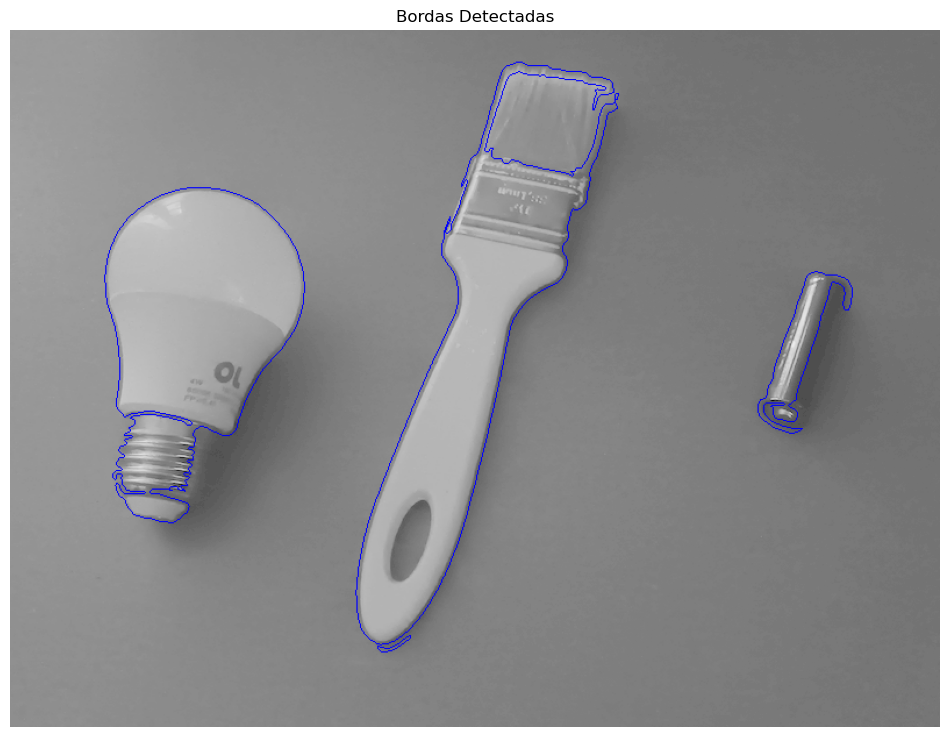

In [12]:
# Exemplo de Imagem Processada
image_path = r'.\deteccaoBorda\log_transform\0388.png '
image = mpimg.imread(image_path)

# Exibir a imagem
plt.figure(figsize=(12, 10)) 
plt.imshow(image)
plt.axis('off')
plt.title('Bordas Detectadas')
plt.show()

### FIM EP3 - Parte 1

<hr style="border: 0; border-top: 10px solid black; width: 85%; margin: 0 auto;">